Load in proc data from prev notebook.
* Try to do initial features and marking if a disease has children


`./proc/{...}`

* Checking for _genetic basis_ of diseases - all diseases from OMIM are genetic, single? 
    * Maybe aklso Orphanet?? 
    
* Check in subset of diseases with `inherited, genetic, Autosomal, recessive, x-link, dominant, congenital`, in name/desc

* model without indirect ev, as that's a probable leak

"However, evidence can sometimes be informative to discriminate targets in similar diseases or phenotypes. For example, when evaluating the inflammatory bowel disease and NOD2 association, other pieces of evidence describing the relationship between Crohn's disease and NOD2 might as well be informative. To approach this problem systematically, the Platform makes use of the properties of the disease ontology (EFO), to select all evidence referring to NOD2 in the context of inflammatory bowel disease or any of its ontology descendants (including Crohn's disease). This type of associations is referred in the platform as indirect associations

* Do train/test split by parent ancestor group , top level
    * By 1 level down (max is 10% for one group) - ~ similar res: 82 vs 83 auc
* Do histogram of pred scores distrib

* get error by source / cat e.g. orphanet
     * Done

* check consistency +- drop duplicates by disease name
    * Model results are about same - 83 AUC

* פירוק לפי דימפטומים, תופעות לוואי, by phenotypes
* count total evidence by source (e.g. # somatic, genetic, etc) + fraction of total from them - for interpretability

---------------

* Using 0/1 instead of evidence score: no change (both get 83.2 AUC on random split)
* Including associated evidence: 93 auc (over ~83)

* Keeping vs dropping `source` col for model (when using grouped by `name`) - 83 vs 79 auc



---- 

* Add single feature model - by source
    * 55.5 AUC
* OPT: eval by source? LOO (for top groups)
* For predicted to have children - plot distribution of actual # children

In [1]:
import pandas as pd
import ast # parse list, etc dtype cols
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import f_classif, chi2,SelectFromModel, mutual_info_classif
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, average_precision_score
from sklearn.feature_selection import SelectFpr, SelectFdr, SelectKBest,VarianceThreshold
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import IsolationForest

from scipy.stats import ttest_rel, chi2, ttest_ind
from Bio import Entrez
from time import sleep
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LogisticRegression

from embetter.grab import ColumnGrabber
from embetter.text import SentenceEncoder

from catboost import Pool, CatBoostClassifier

import shap
shap.initjs()
import matplotlib.pyplot as plt
plt.figure(dpi=1200)
%matplotlib inline
import seaborn

from sklearn import set_config
set_config(transform_output = "pandas")

2023-09-01 01:15:12.919307: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 01:15:12.938866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 01:15:13.277178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-01 01:15:13.664820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


<Figure size 7680x5760 with 0 Axes>

In [2]:
USE_ASSOC = False ## don't use associated evidence (may be leak). ~ 83 (without) vs 93 with it
GET_PREDS = True#

GRPBY_NAME = True#False#True # keep 1 row per name. Changes # data, embedding learning, use name instead of id for joining..

DO_SVD = False # keep raw inputs. MANY cols!!

NAN_THRESH = 30#15 # drop cases with less than this many occs. Reduces model perf, but saves on size/mem

DO_LEAKY_FS = False # Changed to non leaky by default (and now alwyas runs)- just does var (unsupervised) leaky train on train feature sel.. 

DO_DL = True#False

DO_ESEARCH = False
Entrez.email = "dan.ofer@mail.huji.ac.il"

SAVE_OUTPUT = True#False

In [3]:
# dirs = [
# ## todo: rerun with evidences
#         './go',
        
#  './evidence',
#  './evidence/sourceId=chembl',
#  './evidence/sourceId=cancer_gene_census',
#  './evidence/sourceId=europepmc',
#  './evidence/sourceId=crispr',
#  './evidence/sourceId=cancer_biomarkers',
#  './evidence/sourceId=clingen',
#  './diseaseToPhenotype',
#  './targets',
#  './associationByDatasourceDirect',
#  './fda',
#  './fda/significantAdverseDrugReactions',
#  './mechanismOfAction',
#  './indication',
#  './associationByOverallDirect',
#  './associationByOverallIndirect',
#  './diseases',
#  './mousePhenotypes',
#  './molecule',
#  './hpo',
#  './interaction'
#        ]


dirs = [
#     './drugWarnings',
 './diseases',
'./diseaseToPhenotype',
     './associationByOverallDirect',
 './targets',
    './hpo',]

In [4]:
# # https://stackoverflow.com/questions/70009192/how-to-solve-the-issue-of-malformed-node-or-string-error-in-pandas
# import ast


def ddpe(str_val):
    """
    https://stackoverflow.com/questions/70009192/how-to-solve-the-issue-of-malformed-node-or-string-error-in-pandas
    """
    if pd.isna(str_val):  # return NaN if value is NaN
        return np.nan  
    # Remove the square brackets, split on ',' and strip possible
    # whitespaces between elements   
    vals = [v.strip() for v in str_val.strip('[]').split(',')]
    # remove duplicates keeping the original order
    return list(dict.fromkeys(vals)) # ORIG
#     return dict.fromkeys(vals)
# ### doesn't work yet here
# # df["synonyms"].apply(ddpe)
# # df.assign(**pd.DataFrame(df["synonyms"].apply(ddpe)))
# # df.assign(**pd.DataFrame(df["synonyms"].apply(ddpe).values.tolist())) # stuck?

In [5]:
# %%time
# # # pd.read_parquet('./proc/molecule.parquet')
# df_cancer_biomarkers = pd.read_parquet('./evidence/sourceId=cancer_biomarkers')
# df_evidence = pd.read_parquet('./proc/evidence.parquet').dropna(thresh=30,axis=1) ## big file
# print(df_evidence.shape)
# print(df_evidence.nunique())
# display(df_evidence)

#### Diseases raw data
* Doesn't include "features"
* some cols are a list, others an unparsed list. 

* `synonyms` is a dict
    * https://stackoverflow.com/questions/39640936/parsing-a-dictionary-in-a-pandas-dataframe-cell-into-new-row-cells-new-columns

In [6]:
df = pd.read_parquet("./proc/diseases.parquet").dropna(how="all",axis=1)
df = df.drop(columns=["code","directLocationIds","sko"],errors="ignore") ## ,"synonyms"

df["source"] = [i for i in list(df["id"].str.split("_",expand=True)[0])]
# df

##### drop lab measurements
* Also drop these in the feature extraction bits later
* May need to validate that these are indeed not diseases! ? 

In [7]:
df.loc[df["name"].str.contains("index",case=False)]["name"]##["source"].value_counts()

1404                 polydactyly of an index finger
6422                height-adjusted body mass index
6891             underweight body mass index status
8251     polydactyly of an index finger, unilateral
8329              overweight body mass index status
8385                   comprehensive strength index
8713                                body mass index
11191     polydactyly of an index finger, bilateral
11297                          ankle brachial index
12186                  obese body mass index status
12556                           free androgen index
13809                                     IgG index
14019               Insulinogenic index measurement
17299                   left ventricular mass index
19091                 disposition index measurement
20028       pulse wave reflection index measurement
20414    Polydactyly of an index finger, unilateral
20427     Polydactyly of an index finger, bilateral
23000                Polydactyly of an index finger
Name: name, 

In [8]:
print(df.shape[0])
# df = df.loc[~df["name"].str.contains("volume|measurement",case=False)] # 2800 - 10% of dara
df = df.loc[~((df["name"].str.contains("volume|measurement|index",case=False)) & (df["source"]=="EFO"))] ## some index cases are in efo
print(df.shape[0])

23074
20257


In [9]:
df.loc[(df["name"].str.contains("volume|measurement|index",case=False)) & (df["source"]!="EFO")][["name","source"]]

,name,source
1404,polydactyly of an index finger,MONDO
5854,deficient breast volume or number,MONDO
6499,excess breast volume or number,MONDO
8251,"polydactyly of an index finger, unilateral",MONDO
11191,"polydactyly of an index finger, bilateral",MONDO
20414,"Polydactyly of an index finger, unilateral",Orphanet
20427,"Polydactyly of an index finger, bilateral",Orphanet
23000,Polydactyly of an index finger,Orphanet


In [10]:
df.columns

Index(['id', 'description', 'name', 'parents', 'ancestors', 'descendants',
       'children', 'therapeuticAreas', 'synonyms.hasBroadSynonym',
       'synonyms.hasExactSynonym', 'synonyms.hasNarrowSynonym',
       'synonyms.hasRelatedSynonym', 'ontology.isTherapeuticArea',
       'ontology.sources.name', 'source'],
      dtype='object')

In [11]:
df

,id,description,name,parents,ancestors,descendants,children,therapeuticAreas,synonyms.hasBroadSynonym,synonyms.hasExactSynonym,synonyms.hasNarrowSynonym,synonyms.hasRelatedSynonym,ontology.isTherapeuticArea,ontology.sources.name,source
0,DOID_7551,A primary bacterial infectious disease that is...,gonorrhea,"['EFO_0003955', 'MONDO_0000314']","['EFO_0000512', 'EFO_0009663', 'MONDO_0100336'...",[],[],"['MONDO_0100336', 'OTAR_0000017', 'EFO_0005741...",[],['chronic gonococcal infectious disease of upp...,[],"['acrodermatitis, infantile lichenoid', 'Giano...",False,DOID_7551,DOID
1,HP_0000031,The presence of inflammation of the epididymis.,Epididymitis,"['HP_0012649', 'HP_0000022']","['HP_0000022', 'HP_0000078', 'EFO_0000651', 'H...",[],[],['EFO_0000651'],None,None,None,None,False,HP_0000031,HP
2,HP_0000857,None,Neonatal insulin-dependent diabetes mellitus,"['EFO_0000400', 'HP_0001952', 'HP_0000818']","['HP_0000818', 'HP_0000118', 'OTAR_0000020', '...",[],[],"['OTAR_0000020', 'EFO_0000651', 'EFO_0001379',...",None,None,None,None,False,HP_0000857,HP
3,HP_0001693,Pattern of blood flow in the heart that deviat...,Cardiac shunt,['HP_0011028'],"['EFO_0000651', 'HP_0011028', 'HP_0000118', 'H...",['HP_0012382'],['HP_0012382'],['EFO_0000651'],None,None,None,None,False,HP_0001693,HP
4,HP_0001730,A progressive form of hearing impairment.,Progressive hearing impairment,['HP_0000364'],"['HP_0000364', 'EFO_0000651', 'HP_0000598', 'H...",['HP_0000408'],['HP_0000408'],['EFO_0000651'],[],['Progressive hearing loss'],[],[],False,HP_0001730,HP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,Orphanet_721,Gray platelet syndrome (GPS) is a rare inherit...,Gray platelet syndrome,['Orphanet_98455'],"['Orphanet_183654', 'OTAR_0000018', 'Orphanet_...",[],[],"['OTAR_0000018', 'EFO_0005803']",[],"['Platelet alpha-granule deficiency', 'GPS', '...",[],[],False,Orphanet_721,Orphanet
23070,Orphanet_93322,Tibial hemimelia is a rare congenital anomaly ...,Tibial hemimelia,['Orphanet_2130'],"['EFO_0004260', 'Orphanet_404571', 'OTAR_00000...","['Orphanet_295079', 'Orphanet_295077']","['Orphanet_295077', 'Orphanet_295079']","['OTAR_0000006', 'OTAR_0000018']",[],['Congenital longitudinal deficiency of the ti...,[],[],False,Orphanet_93322,Orphanet
23071,Orphanet_93925,Alobar holoprosencephaly is the most severe cl...,Alobar holoprosencephaly,['Orphanet_2162'],"['Orphanet_183763', 'Orphanet_183533', 'OTAR_0...",[],[],"['OTAR_0000018', 'EFO_0001379']",None,None,None,None,False,Orphanet_93925,Orphanet
23072,Orphanet_98539,None,Early-onset ataxia with dementia,['Orphanet_98538'],"['Orphanet_71859', 'Orphanet_183500', 'Orphane...","['Orphanet_247815', 'EFO_0009016', 'EFO_001024...",['Orphanet_1172'],"['OTAR_0000018', 'EFO_0000618']",None,None,None,None,False,Orphanet_98539,Orphanet


In [12]:
# ## synonyms is a dict of lists and has nans when missing. I do this as a proxy feature (better would be to count the # of synonyms, but skip)
# df["hasBroadSynonym"] = ((~df["synonyms"].astype(str).str.contains("'hasBroadSynonym': None")) & (~df["synonyms"].isna())).astype(int)
# df["hasExactSynonym"] = ((~df["synonyms"].astype(str).str.contains("'hasExactSynonym': None")) & (~df["synonyms"].isna())).astype(int)
# df["hasRelatedSynonym"] = ((~df["synonyms"].astype(str).str.contains("'hasRelatedSynonym': None")) & (~df["synonyms"].isna())).astype(int)

# df["Number of synonyms"] = df["synonyms"].str.split("'hasExactSynonym':",expand=True)[1].str.count(",").fillna(0)

# df["Number of synonyms"] = df[['synonyms.hasBroadSynonym', 'synonyms.hasExactSynonym', 'synonyms.hasNarrowSynonym',
#        'synonyms.hasRelatedSynonym']].applymap(lambda x: x.count(",|\[")).fillna(0)

df["Number of synonyms"] =(df['synonyms.hasBroadSynonym'].str.count(",|\[\'")+df['synonyms.hasExactSynonym'].str.count(",|\[\'")+\
df['synonyms.hasNarrowSynonym'].str.count(",|\[\'")+df['synonyms.hasRelatedSynonym'].str.count(",|\[\'")).fillna(0).astype(int)
# df["Has any Synonym"] = df[["hasBroadSynonym","hasExactSynonym","hasRelatedSynonym"]].max(axis=1)
# df.drop(columns=["hasBroadSynonym","hasExactSynonym","hasRelatedSynonym"],inplace=True,errors="ignore")

In [13]:
df

,id,description,name,parents,ancestors,descendants,children,therapeuticAreas,synonyms.hasBroadSynonym,synonyms.hasExactSynonym,synonyms.hasNarrowSynonym,synonyms.hasRelatedSynonym,ontology.isTherapeuticArea,ontology.sources.name,source,Number of synonyms
0,DOID_7551,A primary bacterial infectious disease that is...,gonorrhea,"['EFO_0003955', 'MONDO_0000314']","['EFO_0000512', 'EFO_0009663', 'MONDO_0100336'...",[],[],"['MONDO_0100336', 'OTAR_0000017', 'EFO_0005741...",[],['chronic gonococcal infectious disease of upp...,[],"['acrodermatitis, infantile lichenoid', 'Giano...",False,DOID_7551,DOID,17
1,HP_0000031,The presence of inflammation of the epididymis.,Epididymitis,"['HP_0012649', 'HP_0000022']","['HP_0000022', 'HP_0000078', 'EFO_0000651', 'H...",[],[],['EFO_0000651'],None,None,None,None,False,HP_0000031,HP,0
2,HP_0000857,None,Neonatal insulin-dependent diabetes mellitus,"['EFO_0000400', 'HP_0001952', 'HP_0000818']","['HP_0000818', 'HP_0000118', 'OTAR_0000020', '...",[],[],"['OTAR_0000020', 'EFO_0000651', 'EFO_0001379',...",None,None,None,None,False,HP_0000857,HP,0
3,HP_0001693,Pattern of blood flow in the heart that deviat...,Cardiac shunt,['HP_0011028'],"['EFO_0000651', 'HP_0011028', 'HP_0000118', 'H...",['HP_0012382'],['HP_0012382'],['EFO_0000651'],None,None,None,None,False,HP_0001693,HP,0
4,HP_0001730,A progressive form of hearing impairment.,Progressive hearing impairment,['HP_0000364'],"['HP_0000364', 'EFO_0000651', 'HP_0000598', 'H...",['HP_0000408'],['HP_0000408'],['EFO_0000651'],[],['Progressive hearing loss'],[],[],False,HP_0001730,HP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,Orphanet_721,Gray platelet syndrome (GPS) is a rare inherit...,Gray platelet syndrome,['Orphanet_98455'],"['Orphanet_183654', 'OTAR_0000018', 'Orphanet_...",[],[],"['OTAR_0000018', 'EFO_0005803']",[],"['Platelet alpha-granule deficiency', 'GPS', '...",[],[],False,Orphanet_721,Orphanet,3
23070,Orphanet_93322,Tibial hemimelia is a rare congenital anomaly ...,Tibial hemimelia,['Orphanet_2130'],"['EFO_0004260', 'Orphanet_404571', 'OTAR_00000...","['Orphanet_295079', 'Orphanet_295077']","['Orphanet_295077', 'Orphanet_295079']","['OTAR_0000006', 'OTAR_0000018']",[],['Congenital longitudinal deficiency of the ti...,[],[],False,Orphanet_93322,Orphanet,4
23071,Orphanet_93925,Alobar holoprosencephaly is the most severe cl...,Alobar holoprosencephaly,['Orphanet_2162'],"['Orphanet_183763', 'Orphanet_183533', 'OTAR_0...",[],[],"['OTAR_0000018', 'EFO_0001379']",None,None,None,None,False,Orphanet_93925,Orphanet,0
23072,Orphanet_98539,None,Early-onset ataxia with dementia,['Orphanet_98538'],"['Orphanet_71859', 'Orphanet_183500', 'Orphane...","['Orphanet_247815', 'EFO_0009016', 'EFO_001024...",['Orphanet_1172'],"['OTAR_0000018', 'EFO_0000618']",None,None,None,None,False,Orphanet_98539,Orphanet,0


In [14]:
# ### https://stackoverflow.com/questions/65294592/valueerror-malformed-node-or-string-0-in-pandas

# def get_broad(d):
#     d = d["synonyms"]
#     if pd.isna(d):  # return NaN if value is NaN
#         return np.nan  
#     try:
#         d = ast.literal_eval(d)
#     d = dict.fromkeys(d)
#     return d.get('hasBroadSynonym')
# # df[df["synonyms"].get('hasBroadSynonym')]

# # df[df["synonyms"].apply(get_broad)]
# df[df.apply(get_broad,axis=1)]

# df[df["hasBroadSynonym"]]
# print(list(df[df["hasExactSynonym"]]["synonyms"].head()))

In [15]:
df.loc[df["name"].str.contains("hypertension",case=False)]

,id,description,name,parents,ancestors,descendants,children,therapeuticAreas,synonyms.hasBroadSynonym,synonyms.hasExactSynonym,synonyms.hasNarrowSynonym,synonyms.hasRelatedSynonym,ontology.isTherapeuticArea,ontology.sources.name,source,Number of synonyms
316,MONDO_0005149,Increased pressure within the pulmonary circul...,pulmonary hypertension,['EFO_0000537'],"['MONDO_0000473', 'EFO_0004264', 'EFO_0000537'...","['MONDO_0009937', 'EFO_0009200', 'Orphanet_318...","['MONDO_0012032', 'MONDO_0013458', 'EFO_0001361']",['EFO_0000319'],None,None,None,None,False,MONDO_0005149,MONDO,0
353,MONDO_0007211,Brachydactyly - arterial hypertension is a rar...,brachydactyly-arterial hypertension syndrome,"['MONDO_0018454', 'MONDO_0015512', 'MONDO_0019...","['MONDO_0000473', 'EFO_0004260', 'OTAR_0000006...",[],[],"['OTAR_0000006', 'OTAR_0000018', 'EFO_0009690'...",[],"['Bilginturan syndrome', 'brachydactyly type E...",[],"['HTNB', 'brachydactyly with hypertension', 'b...",False,MONDO_0007211,MONDO,11
410,MONDO_0008347,Idiopathic and/or familial pulmonary arterial ...,idiopathic and/or familial pulmonary arterial ...,"['MONDO_0001999', 'EFO_0001361']","['MONDO_0000473', 'MONDO_0005149', 'EFO_000136...","['MONDO_0009937', 'Orphanet_422', 'MONDO_00093...","['MONDO_0017147', 'MONDO_0017148']","['OTAR_0000010', 'EFO_0000319']",[],['idiopathic and/or familial pulmonary arteria...,[],"['PPH1', 'pulmonary hypertension, primary, 1']",False,MONDO_0008347,MONDO,9
3275,MONDO_0001785,None,malignant secondary hypertension,"['EFO_1002034', 'EFO_1001031']","['MONDO_0000473', 'EFO_1001031', 'EFO_1002034'...",['MONDO_0001784'],['MONDO_0001784'],['EFO_0000319'],None,None,None,None,False,MONDO_0001785,MONDO,0
3604,MONDO_0007781,An instance of essential hypertension that is ...,"essential hypertension, genetic","['MONDO_0015512', 'MONDO_0001134']","['MONDO_0000473', 'MONDO_0001134', 'MONDO_0015...",[],[],"['OTAR_0000018', 'EFO_0009690', 'EFO_0000319']",[],"['hypertension, essential, susceptibility to, ...",[],"['Eht', 'hypertension, essential']",False,MONDO_0007781,MONDO,40
4100,MONDO_0008071,None,autosomal dominant progressive nephropathy wit...,['MONDO_0015512'],"['MONDO_0000473', 'MONDO_0015512', 'OTAR_00000...",[],[],"['OTAR_0000018', 'EFO_0009690', 'EFO_0000319']",[],['nephropathy-hypertension'],[],"['nephropathy, familial', 'RFH1', 'renal failu...",False,MONDO_0008071,MONDO,12
4651,MONDO_0001784,None,malignant renovascular hypertension,"['MONDO_0001785', 'EFO_1002039', 'MONDO_0000959']","['MONDO_0000473', 'EFO_1001031', 'OTAR_0000018...",[],[],"['OTAR_0000018', 'EFO_0009690', 'EFO_0000319']",[],"['malignant renal artery stenosis', 'malignant...",[],[],False,MONDO_0001784,MONDO,2
5286,MONDO_0001134,Hypertension that presents without an identifi...,essential hypertension,['EFO_0000537'],"['MONDO_0000473', 'EFO_0004264', 'EFO_0000537'...",['MONDO_0007781'],['MONDO_0007781'],['EFO_0000319'],[],"['idiopathic hypertension', 'primary hypertens...",[],[],False,MONDO_0001134,MONDO,2
5320,MONDO_0001999,Increased blood pressure in the arteries of th...,primary pulmonary hypertension,['MONDO_0001493'],"['EFO_0003777', 'EFO_0003144', 'EFO_0000373', ...","['MONDO_0009937', 'Orphanet_422', 'MONDO_00093...",['MONDO_0008347'],['EFO_0000319'],[],"['primary pulmonary hypertension', 'pulmonary ...",[],[],False,MONDO_0001999,MONDO,3
6539,MONDO_0015512,An instance of hypertension that is caused by ...,genetic hypertension,"['EFO_0000508', 'EFO_0000537', 'EFO_0003086']","['MONDO_0000473', 'OTAR_0000018', 'EFO_0000508...","['EFO_0007297', 'MONDO_0009937', 'MONDO_001151...","['MONDO_0000959', 'MONDO_0007080', 'MONDO_0007...","['OTAR_0000018', 'EFO_0009690', 'EFO_0000319']",[],"['genetic hypertension', 'genetic hypertensive...",[],[],False,MONDO_0015512,MONDO,2


* Could try also `data=ast.literal_eval(str(map(str,datas.split(','))))`
* there's errors due to `   ['MONDO_0008965' 'MONDO_0009814' 'MONDO_0002182' ... 'MONDO_0014176'`

In [16]:
df.head()["ancestors"].str.split(" ").str.len()

0    12
1     7
2    14
3     5
4     4
Name: ancestors, dtype: int64

In [17]:
# df["descendants"].apply(ast.literal_eval)
df["has_children"] = (df["children"].apply(ast.literal_eval).apply(lambda x: len(x))>0).astype(int) # ORIG

df["num_parents"] = df["parents"].str.split(" ").str.len()-1
df["multiple_parents"] = df["num_parents"]>1 ## cases where is joined from 2 parent sources. Redundnat feature
df["num_ancestors"] = df["ancestors"].str.split(" ").str.len()-1

df["num_therapeuticAreas"] = df["therapeuticAreas"].apply(lambda x: len(x)) # parsed already as list

In [18]:
df["num_therapeuticAreas"].describe().round(1)

count    20257.0
mean        33.7
std         18.7
min         14.0
25%         16.0
50%         32.0
75%         47.0
max        155.0
Name: num_therapeuticAreas, dtype: float64

## Baseline: (Leaky?) Oracle: # siblings at a level
* Oracle baseline feature - how many other diseases, with same direct parent(s). Idea is to catch "wide fans "
    * What about # with subtypes? Too leaky. .
 
* For equivalent comparison, we make the feature here, then will join it to `X` later, after filteirng/train/test split etc.
* We don't keep this as a feature for the main model 

In [19]:
clf_lin = Pipeline([('scaler', StandardScaler()),
                ('LR', LogisticRegressionCV(solver="sag", Cs=5,max_iter=200,n_jobs=-2))])

In [20]:
df["num_siblings"] = df.groupby(["parents"])["id"].transform("size")
df["num_siblings"].describe()
# df.groupby(["parents"])["id"].size().describe()

# # df_parent_sibling_size = df.set_index("id").groupby(["parents"])["id"].size()
# # df_parent_sibling_size

# df.set_index("id").groupby(["parents"])["name"].size().reset_index()

count    20257.000000
mean         9.331046
std         29.909117
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        256.000000
Name: num_siblings, dtype: float64

## Figure - has children distribution hist

In [21]:
df["num_children"] = df["children"].str.split(" ").str.len() -1 ## alt
df["num_children"].describe().round(3)

count    20257.000
mean         1.336
std          8.983
min          0.000
25%          0.000
50%          0.000
75%          0.000
max        585.000
Name: num_children, dtype: float64

In [22]:
df[df["num_children"]>0]["num_children"].describe()

count    4686.000000
mean        5.775288
std        17.978206
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       585.000000
Name: num_children, dtype: float64

#### Hist Num children - done as pie chart at end!

<Axes: >

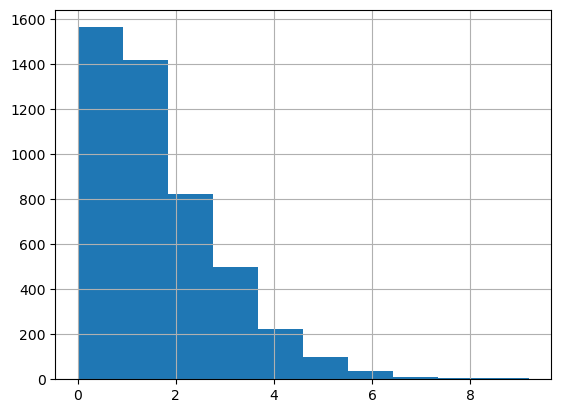

In [23]:
# df["num_children"].hist(label="Diseases with submanifestations distribution")
df[df["num_children"]>0]["num_children"].apply(np.log2).hist(label="Diseases with submanifestations distribution")

In [24]:
df.describe().round(2)

,Number of synonyms,has_children,num_parents,num_ancestors,num_therapeuticAreas,num_siblings,num_children
count,20257.00,20257.00,20257.00,20257.00,20257.00,20257.00,20257.00
mean,5.00,0.33,0.67,10.39,33.74,9.33,1.34
std,6.99,0.47,1.14,8.51,18.75,29.91,8.98
min,0.00,0.00,0.00,0.00,14.00,1.00,0.00
25%,1.00,0.00,0.00,4.00,16.00,1.00,0.00
50%,3.00,0.00,0.00,8.00,32.00,2.00,0.00
75%,7.00,1.00,1.00,14.00,47.00,6.00,0.00
max,104.00,1.00,12.00,70.00,155.00,256.00,585.00


In [25]:
# # ###leak for target)
## min is 1 due to [[]]: 
df["num_children"] = df["children"].str.split(" ").str.len()-1 # changed
df["num_descendants"] = df["descendants"].str.split(" ").str.len()-1

In [26]:
df.select_dtypes(["number"]).groupby(["has_children"]).mean().round(3)

,Number of synonyms,num_parents,num_ancestors,num_therapeuticAreas,num_siblings,num_children,num_descendants
has_children,,,,,,,
0,4.944,0.704,11.358,35.100,10.353,0.000,0.000
1,5.102,0.601,8.419,30.969,7.238,4.073,33.622


In [27]:
# df[['id', 'description', 'name', 'num_children']].to_parquet("raw_df_names.parquet")

In [28]:
df.loc[df["num_children"]>191]

,id,description,name,parents,ancestors,descendants,children,therapeuticAreas,synonyms.hasBroadSynonym,synonyms.hasExactSynonym,...,source,Number of synonyms,has_children,num_parents,multiple_parents,num_ancestors,num_therapeuticAreas,num_siblings,num_children,num_descendants
2079,MONDO_0002320,An abnormality of the nervous system that is p...,congenital nervous system disorder,['EFO_0000618'],['EFO_0000618'],"['MONDO_0008967', 'MONDO_0008965', 'MONDO_0008...","['MONDO_0000087', 'MONDO_0000209', 'MONDO_0000...",['EFO_0000618'],[],"['congenital nervous system disorder', 'congen...",...,MONDO,3,1,0,False,0,15,37,419,821
3402,MONDO_0000508,A intellectual disability that is part of a la...,syndromic intellectual disability,['EFO_0005548'],"['EFO_0000677', 'MONDO_0002025', 'EFO_0005774'...","['MONDO_0008965', 'MONDO_0009814', 'MONDO_0008...","['MONDO_0000087', 'MONDO_0007045', 'MONDO_0007...","['MONDO_0002025', 'EFO_0000618']",[],"['syndromic intellectual disability', 'syndrom...",...,MONDO,2,1,0,False,5,32,3,353,870
7382,EFO_0000508,Genetic diseases are diseases in which inherit...,genetic disorder,['OTAR_0000018'],['OTAR_0000018'],"['Orphanet_2209', 'Orphanet_839', 'Orphanet_83...","['MONDO_0000009', 'MONDO_0000032', 'MONDO_0000...",['OTAR_0000018'],"['genetic disorder', 'genetic disease', 'genet...","['inherited disease', 'hereditary diseases', '...",...,EFO,13,1,0,False,0,16,38,585,11585
7541,MONDO_0015159,None,multiple congenital anomalies/dysmorphic syndr...,['MONDO_0019042'],"['OTAR_0000018', 'MONDO_0019042', 'MONDO_00197...","['MONDO_0007991', 'MONDO_0007874', 'MONDO_0017...","['MONDO_0000179', 'MONDO_0007045', 'MONDO_0007...",['OTAR_0000018'],[],['multiple congenital anomalies-intellectual d...,...,MONDO,3,1,0,False,2,16,4,295,389
11074,MONDO_0043005,An instance of multiple congenital anomalies/d...,genetic multiple congenital anomalies/dysmorph...,"['MONDO_0019042', 'EFO_0000508']","['OTAR_0000018', 'MONDO_0019042', 'EFO_0000508...","['MONDO_0010925', 'MONDO_0008965', 'MONDO_0054...","['MONDO_0000179', 'MONDO_0007045', 'MONDO_0007...",['OTAR_0000018'],[],['hereditary multiple congenital anomalies/dys...,...,MONDO,1,1,1,False,3,16,1,219,607
11245,MONDO_0020119,A syndromic intellectual disability with an X-...,X-linked syndromic intellectual disability,"['MONDO_0000508', 'MONDO_0100284']","['MONDO_0002025', 'OTAR_0000018', 'EFO_0005774...","['Orphanet_79233', 'Orphanet_713', 'MONDO_0010...","['MONDO_0008395', 'MONDO_0010172', 'MONDO_0010...","['MONDO_0002025', 'OTAR_0000018', 'EFO_0000618']",[],"['syndromic X-linked mental retardation', 'int...",...,MONDO,9,1,1,False,12,48,1,200,287
11381,MONDO_0019117,An instance of nervous system disease that is ...,genetic nervous system disorder,"['EFO_0000618', 'EFO_0000508']","['OTAR_0000018', 'EFO_0000508', 'EFO_0000618']","['MONDO_0010808', 'MONDO_0016107', 'MONDO_0016...","['MONDO_0000137', 'MONDO_0000166', 'MONDO_0000...","['OTAR_0000018', 'EFO_0000618']",[],"['genetic neurological disorder', 'genetic ner...",...,MONDO,3,1,1,False,2,31,1,407,3119
19183,Orphanet_183763,None,Rare genetic intellectual disability with deve...,['Orphanet_183757'],"['Orphanet_71859', 'OTAR_0000018', 'Orphanet_1...","['Orphanet_83617', 'Orphanet_98791', 'Orphanet...","['Orphanet_1005', 'Orphanet_1008', 'Orphanet_1...",['OTAR_0000018'],None,None,...,Orphanet,0,1,0,False,3,16,3,217,317


In [29]:
print(df.loc[df["has_children"]>0]["num_children"].clip(upper=40).describe().round(1))
# df.loc[df["has_children"]==1]["num_children"].clip(upper=40).hist()

count    6644.0
mean        3.4
std         6.2
min         0.0
25%         0.0
50%         1.0
75%         4.0
max        40.0
Name: num_children, dtype: float64


## Fig 4 - subtypes per disease in OpenTargets

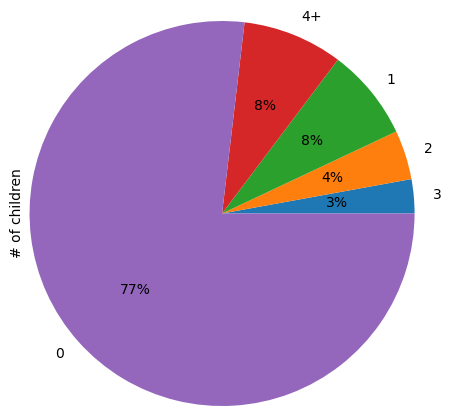

In [30]:
# df["num_children"].plot.pie(subplots=True, figsize=(11, 6))
# Step 1: Group num_children into desired categories
df['grouped_children'] = df['num_children'].apply(lambda x: x if x < 4 else '4+')

# Step 2: Calculate the percentage distribution
child_dist = df['grouped_children'].value_counts(normalize=True).sort_values()
child_dist.plot.pie(label="# of children", figsize=(6, 5), autopct='%1.0f%%').autoscale(tight=True)

df.drop(columns=['grouped_children'],inplace=True)

Top level diseases (?) - use these for filtering groups for validation
* Not - these are very high level! Maybe use a level under them? 


* There are some super common ones, we drop them since we want a level under maybe ? 
* e.g. OTAR_0000018 - "genetic, familial or congenital disease" - 26%, 
OTAR_0000006 - (musculoskeletal or connective tissue disease
) 15%. (the rest are 5% and under)

In [31]:
display(df.loc[df['num_parents']==0])
ZERO_LEVEL_NODES_LIST = list(df.loc[df['num_parents']==0]["id"])
print(len(ZERO_LEVEL_NODES_LIST)," #ZERO_LEVEL_NODES_LIST")

## cases with just 1 ancestor, i.e one level down
## broken due to ancestors not being counted
ONE_LEVEL_NODES_LIST = list(df.loc[(df['num_ancestors']<=2)]["id"]) # maybe expand to handle 0 ases or pairs of ancestor at first split? 
print(len(ONE_LEVEL_NODES_LIST)," #ONE_LEVEL_NODES_LIST")

ONE_LEVEL_NODES_LIST = [ i for i in ONE_LEVEL_NODES_LIST if i != "OTAR_0000018"] ## צשמושךךט גרםפ 2 הקרט יןעי ךקהקך םמקד
ONE_LEVEL_NODES_LIST = [ i for i in ONE_LEVEL_NODES_LIST if i != "OTAR_0000006"]
pattern = '|'.join(ONE_LEVEL_NODES_LIST)
print(len(ONE_LEVEL_NODES_LIST)," #ONE_LEVEL_NODES_LIST")

,id,description,name,parents,ancestors,descendants,children,therapeuticAreas,synonyms.hasBroadSynonym,synonyms.hasExactSynonym,...,source,Number of synonyms,has_children,num_parents,multiple_parents,num_ancestors,num_therapeuticAreas,num_siblings,num_children,num_descendants
3,HP_0001693,Pattern of blood flow in the heart that deviat...,Cardiac shunt,['HP_0011028'],"['EFO_0000651', 'HP_0011028', 'HP_0000118', 'H...",['HP_0012382'],['HP_0012382'],['EFO_0000651'],None,None,...,HP,0,1,0,False,4,15,3,0,0
4,HP_0001730,A progressive form of hearing impairment.,Progressive hearing impairment,['HP_0000364'],"['HP_0000364', 'EFO_0000651', 'HP_0000598', 'H...",['HP_0000408'],['HP_0000408'],['EFO_0000651'],[],['Progressive hearing loss'],...,HP,1,1,0,False,3,15,4,0,0
5,HP_0012076,A personality disorder characterized by impuls...,Borderline personality disorder,['HP_0012075'],"['HP_0000708', 'HP_0012075', 'HP_0012638', 'EF...",[],[],['EFO_0000651'],[],['BPD'],...,HP,1,0,0,False,5,15,1,0,0
6,MONDO_0001493,Heart disease which occurs as a result of a pr...,chronic pulmonary heart disease,['MONDO_0004596'],"['EFO_0003777', 'EFO_0003144', 'EFO_0000373', ...","['MONDO_0009937', 'Orphanet_422', 'MONDO_00093...",['MONDO_0001999'],['EFO_0000319'],['Cor pulmonale'],[],...,MONDO,1,1,0,False,4,15,1,0,8
7,MONDO_0002171,"A benign, intermediate, or malignant tumor tha...",giant cell tumor,['EFO_0000616'],"['MONDO_0023370', 'MONDO_0045024', 'EFO_0000616']","['EFO_1000281', 'MONDO_0002402', 'MONDO_000356...","['MONDO_0002402', 'EFO_1000562']",['MONDO_0045024'],[],"['giant cell tumor (qualifier value)', 'giant ...",...,MONDO,8,1,0,False,2,17,37,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,Orphanet_721,Gray platelet syndrome (GPS) is a rare inherit...,Gray platelet syndrome,['Orphanet_98455'],"['Orphanet_183654', 'OTAR_0000018', 'Orphanet_...",[],[],"['OTAR_0000018', 'EFO_0005803']",[],"['Platelet alpha-granule deficiency', 'GPS', '...",...,Orphanet,3,0,0,False,8,31,2,0,0
23070,Orphanet_93322,Tibial hemimelia is a rare congenital anomaly ...,Tibial hemimelia,['Orphanet_2130'],"['EFO_0004260', 'Orphanet_404571', 'OTAR_00000...","['Orphanet_295079', 'Orphanet_295077']","['Orphanet_295077', 'Orphanet_295079']","['OTAR_0000006', 'OTAR_0000018']",[],['Congenital longitudinal deficiency of the ti...,...,Orphanet,4,1,0,False,14,32,4,1,1
23071,Orphanet_93925,Alobar holoprosencephaly is the most severe cl...,Alobar holoprosencephaly,['Orphanet_2162'],"['Orphanet_183763', 'Orphanet_183533', 'OTAR_0...",[],[],"['OTAR_0000018', 'EFO_0001379']",None,None,...,Orphanet,0,0,0,False,21,31,5,0,0
23072,Orphanet_98539,None,Early-onset ataxia with dementia,['Orphanet_98538'],"['Orphanet_71859', 'Orphanet_183500', 'Orphane...","['Orphanet_247815', 'EFO_0009016', 'EFO_001024...",['Orphanet_1172'],"['OTAR_0000018', 'EFO_0000618']",None,None,...,Orphanet,0,1,0,False,11,31,2,0,49


12298  #ZERO_LEVEL_NODES_LIST
2501  #ONE_LEVEL_NODES_LIST
2499  #ONE_LEVEL_NODES_LIST


In [32]:
## https://stackoverflow.com/questions/17972938/check-if-a-string-in-a-pandas-dataframe-column-is-in-a-list-of-strings
import re
def pattern_searcher(search_str:str, search_list:str):

    search_obj = re.search(search_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = ""#'NA'
    return return_str

df["t"] = df["ancestors"].str.split(" ").astype(str).str.replace("[","",regex=False).str.replace("]","",regex=False)
df["grp"] = df['t'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))
print(df["grp"].value_counts(normalize=True))

# #### replace with counts - will reduce noise due to ~71 grps with 1 occurrence - maybe not needed? 
# df["grp"] = df.groupby(["grp"])["has_children"].transform("size").values
df["grp"] = df["grp"].astype("str") # to avoid it being used as a feature
print(df["grp"].value_counts())

grp
EFO_0004260       0.100064
MONDO_0002025     0.050402
EFO_0009676       0.044627
EFO_0000589       0.040184
Orphanet_71859    0.038012
                    ...   
MONDO_0001045     0.000049
MONDO_0001147     0.000049
MONDO_0021043     0.000049
MONDO_0015193     0.000049
MONDO_0000820     0.000049
Name: proportion, Length: 418, dtype: float64
grp
EFO_0004260       2027
MONDO_0002025     1021
EFO_0009676        904
EFO_0000589        814
Orphanet_71859     770
                  ... 
MONDO_0001045        1
MONDO_0001147        1
MONDO_0021043        1
MONDO_0015193        1
MONDO_0000820        1
Name: count, Length: 418, dtype: int64


* todo: check cases where parent has only 1 child, i.e cases of child being the same as parent ? 

In [33]:
keep_cols_list = list(df.select_dtypes(["number","bool"]).columns) + ['id', 'description', 'name',"grp"]

In [34]:
##orig:
# df = df[['id', 'description', 'name',
# #          'ontology',
#          'hasBroadSynonym', 'hasExactSynonym', 'hasRelatedSynonym', # extracted from ontology
#          'has_children',
#        'num_parents', "multiple_parents",'num_ancestors', 'num_therapeuticAreas',"grp"]]
## new:

df = df.filter(keep_cols_list,axis=1)
df.drop(columns=["num_children","num_descendants"],axis=1,errors="ignore",inplace=True)
display(df.describe().round(2))
df

,Number of synonyms,has_children,num_parents,num_ancestors,num_therapeuticAreas,num_siblings
count,20257.00,20257.00,20257.00,20257.00,20257.00,20257.00
mean,5.00,0.33,0.67,10.39,33.74,9.33
std,6.99,0.47,1.14,8.51,18.75,29.91
min,0.00,0.00,0.00,0.00,14.00,1.00
25%,1.00,0.00,0.00,4.00,16.00,1.00
50%,3.00,0.00,0.00,8.00,32.00,2.00
75%,7.00,1.00,1.00,14.00,47.00,6.00
max,104.00,1.00,12.00,70.00,155.00,256.00


,ontology.isTherapeuticArea,Number of synonyms,has_children,num_parents,multiple_parents,num_ancestors,num_therapeuticAreas,num_siblings,id,description,name,grp
0,False,17,0,1,False,11,63,1,DOID_7551,A primary bacterial infectious disease that is...,gonorrhea,EFO_0000512
1,False,0,0,1,False,6,15,1,HP_0000031,The presence of inflammation of the epididymis.,Epididymitis,HP_0000022
2,False,0,0,2,True,13,76,1,HP_0000857,None,Neonatal insulin-dependent diabetes mellitus,HP_0000818
3,False,0,1,0,False,4,15,3,HP_0001693,Pattern of blood flow in the heart that deviat...,Cardiac shunt,EFO_0000651
4,False,1,1,0,False,3,15,4,HP_0001730,A progressive form of hearing impairment.,Progressive hearing impairment,HP_0000364
...,...,...,...,...,...,...,...,...,...,...,...,...
23069,False,3,0,0,False,8,31,2,Orphanet_721,Gray platelet syndrome (GPS) is a rare inherit...,Gray platelet syndrome,EFO_0000508
23070,False,4,1,0,False,14,32,4,Orphanet_93322,Tibial hemimelia is a rare congenital anomaly ...,Tibial hemimelia,EFO_0004260
23071,False,0,0,0,False,21,31,5,Orphanet_93925,Alobar holoprosencephaly is the most severe cl...,Alobar holoprosencephaly,Orphanet_183533
23072,False,0,1,0,False,11,31,2,Orphanet_98539,None,Early-onset ataxia with dementia,Orphanet_71859


In [35]:
df["id"] = df["id"].astype(str)
df["ids"] = df["id"].astype(str) # For SB
df["source"] = [i for i in list(df["id"].str.split("_",expand=True)[0])]
df["parents_div_ancestors"] = df['num_parents'].div(df['num_ancestors'])
df["ancestors_sub_parents"] = df['num_ancestors'].sub(df['num_parents'])
df.columns = df.columns.astype(str)
df["name"] = df["name"].str.lower().str.strip()

In [36]:
## added here
if GRPBY_NAME:
    s1 = df.shape[0]
    print(df.shape)
    print(df["has_children"].mean(), "% target")
    df["has_children"]  = df.groupby("name")["has_children"].transform(max)
    
    #ORIGL: # df.drop_duplicates(subset=["name"],inplace=True) # Drop by label also? keep cases of no child preferentially?
    ### NEW / ALT: Get first 
    df = df.groupby("name").first().reset_index() # alt - new 
    print(df.shape[0])
    print(s1-df.shape[0]," rows dropped")
    print(df["has_children"].mean(), "% target")

(20257, 16)
0.3279853877671916 % target
17222
3035  rows dropped
0.3395656718151202 % target


### Features
##### association By Overall Direct

* Direct evidence - what sources? Seemso nly genetic

In [37]:
df_assoc = pd.read_parquet("./proc/associationByOverallDirect.parquet",columns=['diseaseId', 'targetId',"score"])## no dupes #.drop_duplicates()

print(df_assoc.iloc[:,0:2].nunique())
df_assoc

diseaseId    16578
targetId     29221
dtype: int64


,diseaseId,targetId,score
0,DOID_0050890,ENSG00000006128,0.002217
1,DOID_0050890,ENSG00000006210,0.002217
2,DOID_0050890,ENSG00000007952,0.003495
3,DOID_0050890,ENSG00000010256,0.003696
4,DOID_0050890,ENSG00000010610,0.005359
...,...,...,...
2120903,Orphanet_999,ENSG00000023318,0.037246
2120904,Orphanet_999,ENSG00000075539,0.042908
2120905,Orphanet_999,ENSG00000156171,0.046552
2120906,Orphanet_999,ENSG00000178409,0.046552


In [38]:
df_assoc.nunique()

diseaseId     16578
targetId      29221
score        690014
dtype: int64

In [39]:
df_assoc["score"].describe().round(3)

count    2120908.000
mean           0.062
std            0.106
min            0.001
25%            0.004
50%            0.030
75%            0.053
max            0.903
Name: score, dtype: float64

In [40]:
# df_assoc.sample(234)["targetId"].str.split("0",expand=True)[0].unique() # same value for all

### add agg/count feats for gene assoc - may be redundnat! (We already have elsewhere with evidence)

In [41]:
df_assoc_agg = df_assoc.groupby(["diseaseId"]).agg(
    nunique_associated_evidence_targets=('targetId', 'nunique'),
    average_associated_evidence_score=('score', 'mean'),
    highest_associated_evidence_score=('score', 'max'),
    # associated_evidence_score_STD=('score', 'std'),
)
df_assoc_agg

,nunique_associated_evidence_targets,average_associated_evidence_score,highest_associated_evidence_score
diseaseId,,,
DOID_0050890,265,0.007296,0.079678
DOID_10113,97,0.015784,0.469687
DOID_10718,93,0.005787,0.041393
DOID_13406,241,0.023028,0.369580
DOID_1947,36,0.004491,0.012697
...,...,...,...
Orphanet_99946,54,0.048630,0.461975
Orphanet_99947,81,0.050772,0.820240
Orphanet_99960,45,0.049930,0.750537


#### Pivot feats and filter out rare genes

In [42]:
%%time
# ALT - ignore evidence score:
# df_assoc["score"] = 1 # dummy col

df_assoc_pivot = df_assoc.pivot(values=["score"], index=["diseaseId"], columns=["targetId"])

display(df_assoc_pivot)
print(df_assoc_pivot.shape)
df_assoc_pivot = df_assoc_pivot.dropna(thresh=NAN_THRESH,axis=1).fillna(0) # change from 20 to NAN_THRESH
print(df_assoc_pivot.shape)

df_assoc_pivot.columns = list(map("_".join,df_assoc_pivot.columns))
# df_assoc_pivot#.reset_index(inplace=True)
display(df_assoc_pivot)
# ## t ocsv is sloooow!!!
# df_assoc_pivot.to_csv("associationByOverallDirect_mat.csv")

score                                  \
targetId       ENSG00000000003 ENSG00000000005 ENSG00000000419   
diseaseId                                                        
DOID_0050890               NaN             NaN             NaN   
DOID_10113                 NaN             NaN             NaN   
DOID_10718                 NaN             NaN             NaN   
DOID_13406                 NaN             NaN             NaN   
DOID_1947                  NaN             NaN             NaN   
...                        ...             ...             ...   
Orphanet_99946             NaN             NaN             NaN   
Orphanet_99947             NaN             NaN             NaN   
Orphanet_99960             NaN             NaN             NaN   
Orphanet_99961             NaN             NaN             NaN   
Orphanet_99989             NaN             NaN             NaN   

                                                                \
targetId       ENSG00000000457 ENSG00000000460 ENSG00000000938   
diseaseId                                                        
DOID_0050890               NaN             NaN             NaN   
DOID_10113                 NaN             NaN             NaN   
DOID_10718                 NaN             NaN             NaN   
DOID_13406                 NaN             NaN             NaN   
DOID_1947                  NaN             NaN             NaN   
...                        ...             ...             ...   
Orphanet_99946             NaN             NaN             NaN   
Orphanet_99947             NaN             NaN             NaN   
Orphanet_99960             NaN             NaN             NaN   
Orphanet_99961             NaN             NaN             NaN   
Orphanet_99989             NaN             NaN             NaN   

                                                                \
targetId       ENSG00000000971 ENSG00000001036 ENSG00000001084   
diseaseId                                                        
DOID_0050890               NaN             NaN             NaN   
DOID_10113                 NaN             NaN             NaN   
DOID_10718                 NaN             NaN             NaN   
DOID_13406                 NaN             NaN             NaN   
DOID_1947                  NaN             NaN             NaN   
...                        ...             ...             ...   
Orphanet_99946             NaN             NaN             NaN   
Orphanet_99947             NaN             NaN             NaN   
Orphanet_99960             NaN             NaN             NaN   
Orphanet_99961             NaN             NaN             NaN   
Orphanet_99989             NaN             NaN             NaN   

                                ...                                  \
targetId       ENSG00000001167  ... ENSG00000288864 ENSG00000288867   
diseaseId                       ...                                   
DOID_0050890               NaN  ...             NaN             NaN   
DOID_10113                 NaN  ...             NaN             NaN   
DOID_10718                 NaN  ...             NaN             NaN   
DOID_13406                 NaN  ...             NaN             NaN   
DOID_1947                  NaN  ...             NaN             NaN   
...                        ...  ...             ...             ...   
Orphanet_99946             NaN  ...             NaN             NaN   
Orphanet_99947             NaN  ...             NaN             NaN   
Orphanet_99960             NaN  ...             NaN             NaN   
Orphanet_99961             NaN  ...             NaN             NaN   
Orphanet_99989             NaN  ...             NaN             NaN   

                                                                \
targetId       ENSG00000288920 ENSG00000288944 ENSG00000289027   
diseaseId                                                        
DOID_0050890               NaN             NaN           

(16578, 29221)
(16578, 13705)


,score_ENSG00000000003,score_ENSG00000000005,score_ENSG00000000419,score_ENSG00000000457,score_ENSG00000000460,score_ENSG00000000938,score_ENSG00000000971,score_ENSG00000001084,score_ENSG00000001167,score_ENSG00000001461,...,score_ENSG00000286112,score_ENSG00000286522,score_ENSG00000287080,score_ENSG00000288357,score_ENSG00000288534,score_ENSG00000288602,score_ENSG00000288611,score_ENSG00000288642,score_ENSG00000288702,score_ENSG00000288705
diseaseId,,,,,,,,,,,,,,,,,,,,,
DOID_0050890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_13406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_1947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CPU times: user 1.48 s, sys: 2.44 s, total: 3.92 s
Wall time: 2.58 s


In [43]:
df_pheno = pd.read_parquet("./proc/diseaseToPhenotype.parquet",columns=["disease","phenotype"])#.drop_duplicates() - same size
display(df_pheno)

# df_pheno[["disease","phenotype"]].drop_duplicates().to_csv("diseaseToPhenotype.csv.gz",index=False,compression="gzip")
print(df_pheno.shape)

,disease,phenotype
0,EFO_0000182,HP_0001413
1,EFO_0000222,HP_0000006
2,EFO_0000239,HP_0003574
3,EFO_0000272,HP_0009592
4,EFO_0000274,HP_0001041
...,...,...
206499,Orphanet_99939,HP_0003431
206500,Orphanet_99943,HP_0000408
206501,Orphanet_99944,HP_0001288
206502,Orphanet_99947,HP_0001609


(206504, 2)


In [44]:
df_pheno.nunique()

disease      8423
phenotype    9125
dtype: int64

In [45]:
df_pheno["phenotype"].value_counts()

phenotype
HP_0000007    4206
HP_0000006    3489
HP_0001249    1931
HP_0001250    1776
HP_0001263    1756
              ... 
HP_0012633       1
HP_0012631       1
HP_0011766       1
HP_0011215       1
HP_0030866       1
Name: count, Length: 9125, dtype: int64

In [46]:
df_pheno["phenotype"].value_counts().describe().round(1) ## most phenotypes are rare

count    9125.0
mean       22.6
std        91.0
min         1.0
25%         2.0
50%         5.0
75%        14.0
max      4206.0
Name: count, dtype: float64

#### NOTE: Pheno frequency code changed! is it different?? 

In [47]:
### add overall frequency of each phenotype (and then aggregate it later) - 
## name is misleading! it's not yet avg here


# ##orig - failed now in newer pandas version? : 
# df_pheno_frequency = df_pheno.merge(df_pheno["phenotype"].value_counts().reset_index(name="avg_phenotype_freq"),
#                                     left_on="disease",right_on="index")
## newer try (DIFFERENT from ORIGINAL code/results???):
df_pheno_frequency = df_pheno.merge(df_pheno["phenotype"].value_counts().reset_index(name="avg_phenotype_freq"),
                                    on="phenotype")
df_pheno_frequency.drop(columns={"index"},inplace=True,errors="ignore") ## "index col not found in new merge"
# disease
## was always ocmmented out: 
# df_pheno_frequency =df_pheno_frequency.groupby("phenotype",as_index=False)["avg_phenotype_freq"].median()#.reset_index(name="median_phenotype_freq")
df_pheno_frequency

,disease,phenotype,avg_phenotype_freq
0,EFO_0000182,HP_0001413,22
1,MONDO_0008814,HP_0001413,22
2,Orphanet_279934,HP_0001413,22
3,MONDO_0011624,HP_0001413,22
4,Orphanet_404454,HP_0001413,22
...,...,...,...
206499,Orphanet_90673,HP_0011789,1
206500,Orphanet_93320,HP_0003967,1
206501,Orphanet_93397,HP_0010348,1
206502,Orphanet_96190,HP_0011327,1


In [48]:
# df_pheno_frequency["median_avg_phenotype_freq"] = df_pheno_frequency.groupby("disease",as_index=False)["avg_phenotype_freq"].transform("median")
df_pheno_frequency["mean_phenotype_frequency"] = df_pheno_frequency.groupby("disease",as_index=False)["avg_phenotype_freq"].transform("mean").round(1)

### strng feature (max), but annoying to explain:
# if not DISABLE_agg_pheno:
df_pheno_frequency["max_phenotype_frequency"] = df_pheno_frequency.groupby("disease",as_index=False)["avg_phenotype_freq"].transform("max").fillna(0)
df_pheno_frequency["min_phenotype_frequency"] = df_pheno_frequency.groupby("disease",as_index=False)["avg_phenotype_freq"].transform("min").fillna(0)

## nunq - strong feature but redundnat
# df_pheno_frequency["nunique_avg_phenotype_freq"] = df_pheno_frequency.groupby("disease",as_index=False)["avg_phenotype_freq"].transform("nunique")
print(df_pheno_frequency.shape[0]) # multuple rows - per disease X phenotype before we drop
df_pheno_frequency = df_pheno_frequency.drop(columns=["phenotype","avg_phenotype_freq"],axis=1).drop_duplicates()
print(df_pheno_frequency.shape[0])
df_pheno_frequency

206504
8423


,disease,mean_phenotype_frequency,max_phenotype_frequency,min_phenotype_frequency
0,EFO_0000182,102.6,300,3
1,MONDO_0008814,510.4,4206,2
2,Orphanet_279934,468.2,4206,2
3,MONDO_0011624,364.4,4206,22
4,Orphanet_404454,226.0,4206,1
...,...,...,...,...
205171,EFO_0004609,2.0,2,2
205172,EFO_0009266,2.0,2,2
205528,EFO_1000973,1.0,1,1
206306,EFO_0003764,1.0,1,1


In [49]:
df_pheno_frequency.nunique()

disease                     8423
mean_phenotype_frequency    4810
max_phenotype_frequency      179
min_phenotype_frequency      182
dtype: int64

##### count total associated phenotypes
* merge this  seperately from the pivoted

In [50]:
df_pheno_counts = df_pheno.groupby("disease")["phenotype"].size().reset_index(name="Phenotype_counts")
df_pheno_counts = df_pheno_counts.merge(df_pheno_frequency,on="disease",how="left")
assert df_pheno_counts.dropna(axis=1,how="all").shape[1] == df_pheno_counts.shape[1]
df_pheno_counts

,disease,Phenotype_counts,mean_phenotype_frequency,max_phenotype_frequency,min_phenotype_frequency
0,EFO_0000095,5,730.0,3489,2
1,EFO_0000174,2,73.5,143,4
2,EFO_0000178,3,53.7,143,8
3,EFO_0000181,2,2123.5,4206,41
4,EFO_0000182,5,102.6,300,3
...,...,...,...,...,...
8418,Orphanet_99945,13,515.2,3489,11
8419,Orphanet_99946,19,335.7,3489,7
8420,Orphanet_99947,68,210.0,3489,2
8421,Orphanet_99960,9,629.0,4206,8


In [51]:
df_pheno["value"] = 1 # dummy col
df_pheno_pivot = df_pheno.pivot(index=["disease"], columns=["phenotype"])

df_pheno_pivot = df_pheno_pivot.dropna(thresh=20,axis=1) # drop a few K cols
df_pheno_pivot = df_pheno_pivot.fillna(0).astype(int)
print(df_pheno_pivot.shape)

df_pheno_pivot.columns = list(map("_".join,df_pheno_pivot.columns))
display(df_pheno_pivot)

(8423, 1825)


,value_HP_0000003,value_HP_0000006,value_HP_0000007,value_HP_0000010,value_HP_0000011,value_HP_0000012,value_HP_0000013,value_HP_0000016,value_HP_0000020,value_HP_0000023,...,value_HP_0200034,value_HP_0200039,value_HP_0200041,value_HP_0200042,value_HP_0200055,value_HP_0200097,value_HP_0200134,value_HP_0200136,value_HP_0410030,value_HP_0410263
disease,,,,,,,,,,,,,,,,,,,,,
EFO_0000095,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EFO_0000174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EFO_0000178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EFO_0000181,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EFO_0000182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99945,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Orphanet_99946,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Orphanet_99947,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Could add feature about evidence count - distrib, sum, # cases of a source with at least 3 evidence counts (i.e "Reliable")?

In [60]:
try:
    df_sources = pd.read_parquet('./associationByDatasourceDirect')#.head(12345)
except:
    df_sources = pd.read_parquet('./proc/associationByDatasourceDirect.parquet') # new
print(df_sources.nunique())
df_sources

datatypeId            7
datasourceId         22
diseaseId         16578
targetId          29221
score            683845
evidenceCount      1771
dtype: int64


,datatypeId,datasourceId,diseaseId,targetId,score,evidenceCount
0,known_drug,chembl,DOID_10113,ENSG00000113578,0.531939,2
1,known_drug,chembl,DOID_10113,ENSG00000115758,0.769201,4
2,known_drug,chembl,DOID_13406,ENSG00000065989,0.121586,1
3,known_drug,chembl,DOID_13406,ENSG00000073417,0.121586,1
4,known_drug,chembl,DOID_13406,ENSG00000095464,0.121586,1
...,...,...,...,...,...,...
2261986,genetic_association,gene2phenotype,Orphanet_99853,ENSG00000115211,0.607931,1
2261987,genetic_association,gene2phenotype,Orphanet_99853,ENSG00000145191,0.607931,1
2261988,genetic_association,gene2phenotype,Orphanet_99880,ENSG00000134371,0.607931,1
2261989,genetic_association,gene2phenotype,Orphanet_99886,ENSG00000204644,0.607931,1


In [61]:
df_sources["evidenceCount"].describe().round(2)

count    2261991.00
mean           6.38
std           89.19
min            1.00
25%            1.00
50%            1.00
75%            2.00
max        34152.00
Name: evidenceCount, dtype: float64

In [62]:
## currently not used
df_sources_highEvidence = df_sources.drop(columns=["score"]).groupby(['datatypeId', 'datasourceId', 'diseaseId', 'targetId']).sum().reset_index()
print(df_sources_highEvidence["evidenceCount"].describe().round(2)) ## same
df_sources_highEvidence = df_sources_highEvidence.loc[df_sources_highEvidence["evidenceCount"]>=3].iloc[:,0:3].drop_duplicates()
print(df_sources_highEvidence.nunique())
df_sources_highEvidence

count    2261991.00
mean           6.38
std           89.19
min            1.00
25%            1.00
50%            1.00
75%            2.00
max        34152.00
Name: evidenceCount, dtype: float64
datatypeId          7
datasourceId       17
diseaseId       12069
dtype: int64


,datatypeId,datasourceId,diseaseId
5,affected_pathway,cancer_biomarkers,EFO_0000178
13,affected_pathway,cancer_biomarkers,EFO_0000181
21,affected_pathway,cancer_biomarkers,EFO_0000182
28,affected_pathway,cancer_biomarkers,EFO_0000220
41,affected_pathway,cancer_biomarkers,EFO_0000222
...,...,...,...
2261665,somatic_mutation,intogen,MONDO_0002691
2261745,somatic_mutation,intogen,MONDO_0007576
2261802,somatic_mutation,intogen,MONDO_0008170
2261853,somatic_mutation,intogen,MONDO_0011962


In [63]:
df_sources["datatypeId"].value_counts()

datatypeId
literature             1016211
animal_model            523293
genetic_association     381578
rna_expression          161620
somatic_mutation         78536
known_drug               72366
affected_pathway         28387
Name: count, dtype: int64

In [64]:
df_sources["datasourceId"].value_counts()

datasourceId
europepmc             1016211
impc                   523293
ot_genetics_portal     307131
expression_atlas       161620
cancer_gene_census      74345
chembl                  72366
eva                     27989
slapenrich              22957
genomics_england        12067
orphanet                 8474
uniprot_variants         7639
uniprot_literature       7378
gene_burden              5379
gene2phenotype           3581
reactome                 2404
eva_somatic              2137
intogen                  2054
clingen                  1940
crispr                   1846
cancer_biomarkers         467
progeny                   378
sysbio                    335
Name: count, dtype: int64

In [69]:
df_sources_agg1 = df_sources.groupby(["diseaseId"]).agg(#
    datasource_nunique=('datasourceId', 'nunique'),
    datasources_count=('datasourceId', 'count'),
    datatype_nunique=('datatypeId', 'nunique'),
    evidenceCount_byDisease_avg =("evidenceCount","mean"),
    evidenceCount_byDisease_sum =("evidenceCount","sum"),
#     datatype_count=('datatypeId', 'count'), # same as above, it's not per source
)
df_sources_agg1

,datasource_nunique,datasources_count,datatype_nunique,evidenceCount_byDisease_avg,evidenceCount_byDisease_sum
diseaseId,,,,,
DOID_0050890,1,265,1,11.143396,2953
DOID_10113,3,99,3,1.929293,191
DOID_10718,1,93,1,2.655914,247
DOID_13406,2,244,2,4.356557,1063
DOID_1947,1,36,1,2.027778,73
...,...,...,...,...,...
Orphanet_99946,3,55,2,1.581818,87
Orphanet_99947,7,86,3,2.581395,222
Orphanet_99960,6,52,3,1.596154,83


In [70]:
df_sources_agg = df_sources.groupby(["diseaseId"],as_index=False)["datatypeId"].value_counts()

df_sources_agg = df_sources_agg.pivot(index=["diseaseId"], columns=["datatypeId"]).reset_index().set_index("diseaseId")
df_sources_agg.columns = [i[1] for i in list(df_sources_agg.columns)]
print(df_sources_agg.columns)
num_agg_cols = df_sources_agg.columns
df_sources_agg["total_source_cases"] = df_sources_agg.filter(num_agg_cols,axis=1).sum(axis=1)
df_sources_agg["max_source_cases"] = df_sources_agg.filter(num_agg_cols,axis=1).max(axis=1)
df_sources_agg["min_source_cases"] = df_sources_agg.filter(num_agg_cols,axis=1).min(axis=1)
for c in num_agg_cols:
    df_sources_agg[f"pct_{c}"] = (100*df_sources_agg[c].div(df_sources_agg["total_source_cases"])).round(4)
    df_sources_agg[f"{c}_is_biggest"] = (df_sources_agg[c]==df_sources_agg["max_source_cases"]).astype(int)# added
    df_sources_agg[f"{c}_is_smallest"] = df_sources_agg[c]==df_sources_agg["min_source_cases"].astype(int)# added
    df_sources_agg[f"{c}_ratio_to_biggest"] = df_sources_agg[c].div(df_sources_agg["max_source_cases"]).round(3)
    df_sources_agg[f"{c}_ratio_to_smallest"] = df_sources_agg[c].div(df_sources_agg["min_source_cases"]).round(3)

# get PCT. Get rank / rank of highest? 
df_sources_agg = df_sources_agg.dropna(thresh=20,axis=1).fillna(0) ## ADDED new


Index(['affected_pathway', 'animal_model', 'genetic_association', 'known_drug',
       'literature', 'rna_expression', 'somatic_mutation'],
      dtype='object')


In [71]:
df_sources_agg = df_sources_agg.join(df_sources_agg1,how="outer").dropna(thresh=NAN_THRESH,axis=1).fillna(0)
df_sources_agg

,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation,total_source_cases,max_source_cases,min_source_cases,...,pct_somatic_mutation,somatic_mutation_is_biggest,somatic_mutation_is_smallest,somatic_mutation_ratio_to_biggest,somatic_mutation_ratio_to_smallest,datasource_nunique,datasources_count,datatype_nunique,evidenceCount_byDisease_avg,evidenceCount_byDisease_sum
diseaseId,,,,,,,,,,,,,,,,,,,,,
DOID_0050890,0.0,0.0,0.0,0.0,265.0,0.0,0.0,265.0,265.0,265.0,...,0.0000,0,False,0.000,0.0,1,265,1,11.143396,2953
DOID_10113,0.0,0.0,1.0,2.0,96.0,0.0,0.0,99.0,96.0,1.0,...,0.0000,0,False,0.000,0.0,3,99,3,1.929293,191
DOID_10718,0.0,0.0,0.0,0.0,93.0,0.0,0.0,93.0,93.0,93.0,...,0.0000,0,False,0.000,0.0,1,93,1,2.655914,247
DOID_13406,0.0,0.0,0.0,35.0,209.0,0.0,0.0,244.0,209.0,35.0,...,0.0000,0,False,0.000,0.0,2,244,2,4.356557,1063
DOID_1947,0.0,0.0,0.0,0.0,36.0,0.0,0.0,36.0,36.0,36.0,...,0.0000,0,False,0.000,0.0,1,36,1,2.027778,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99946,0.0,53.0,2.0,0.0,0.0,0.0,0.0,55.0,53.0,2.0,...,0.0000,0,False,0.000,0.0,3,55,2,1.581818,87
Orphanet_99947,0.0,80.0,5.0,0.0,0.0,0.0,1.0,86.0,80.0,1.0,...,1.1628,0,True,0.012,1.0,7,86,3,2.581395,222
Orphanet_99960,0.0,43.0,4.0,0.0,5.0,0.0,0.0,52.0,43.0,4.0,...,0.0000,0,False,0.000,0.0,6,52,3,1.596154,83


In [72]:
df = df.merge(df_sources_agg,how="left",right_index=True,left_on="id",validate="m:1")
print(df.shape)

(17222, 66)


In [73]:
assert df.merge(df_pheno_counts.rename(columns={"disease":"id"}),how="left").shape[0] <40_000

In [74]:
df = df.merge(df_pheno_counts.rename(columns={"disease":"id"}),how="left")

In [75]:
df = df.merge(df_assoc_agg,left_on="id",right_index=True,how="left")

### add count s in pop of diseases/icd codes.
* warning - what about multiple cases / codes per disease? 
* Also - many lack coverage

`"disease_icd10_counts_v1.csv"`

Data from UK BioBank
* This is meant to test if adding the frequency of a disease aids the model. We found that no, (adding this feature didn't improve model perf)/ 

In [76]:
df_icd_counts = pd.read_csv("disease_icd10_counts_v1.csv")
print(df_icd_counts.nunique())

### for nw - random drop duplicates!
df_icd_counts = df_icd_counts.sort_values(by="f41202_ICD_counts",ascending=True).drop_duplicates(subset=["id"])
df_icd_counts = df_icd_counts.set_index("id").select_dtypes(["number"])

# df_icd_counts

id                   8445
dbXRefs              1518
ICD10                 663
All_ICD_counts        441
f41202_ICD_counts     339
ICD10_all_freq        441
dtype: int64


In [77]:
df = df.join(df_icd_counts,how="left")

In [78]:
## added - new
df.reset_index(inplace=True,drop=True)

In [79]:
# pd.read_parquet("./proc/hpo.parquet")[["description","id"]].rename(columns={"id":"fid"}).to_csv("hpo.csv.gz",index=False)

In [80]:
%%time
if USE_ASSOC:
    df_assoc_indir = pd.read_parquet("./proc/associationByOverallIndirect.parquet")[["diseaseId","targetId","score"]]
    # df_assoc_indir[["diseaseId","targetId"]].to_csv("associationByOverallIndirect.csv.gz",index=False)

    df_assoc_indir = df_assoc_indir.pivot(values=["score"], index=["diseaseId"], columns=["targetId"])
    display(df_assoc_indir)
    print(df_assoc_indir.shape)
    df_assoc_indir = df_assoc_indir.dropna(thresh=NAN_THRESH,axis=1) # drop a few K cols
    df_assoc_indir = df_assoc_indir.fillna(0)
    print(df_assoc_indir.shape)

    df_assoc_indir.columns = list(map("_".join,df_assoc_indir.columns))
    # df_assoc_indir#.reset_index(inplace=True)
    display(df_assoc_indir)
    # ## t ocsv is sloooow!!!
    # df_assoc_indir.to_csv("associationByOverallDirect_mat.csv")

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


### merge multiple features sources together, then decompose

In [81]:
%%time
if USE_ASSOC:
    df_merged_pivots = df_assoc_pivot.join(df_assoc_indir,how="outer",lsuffix = '_direct',rsuffix="indirect")
else:
    df_merged_pivots = df_assoc_pivot
print(df_merged_pivots.shape)
df_merged_pivots = df_merged_pivots.join(df_pheno_pivot,how="outer",rsuffix="pheno")
print(df_merged_pivots.shape)
## new 
df_merged_pivots = VarianceThreshold(0.00006).fit_transform(df_merged_pivots)

df_merged_pivots.fillna(0,inplace=True) # slow for some reason?
df_merged_pivots

(16578, 13705)
(17159, 15530)
CPU times: user 3.29 s, sys: 959 ms, total: 4.25 s
Wall time: 4.25 s


,score_ENSG00000000419,score_ENSG00000000938,score_ENSG00000000971,score_ENSG00000001084,score_ENSG00000001617,score_ENSG00000001626,score_ENSG00000001630,score_ENSG00000001631,score_ENSG00000002016,score_ENSG00000002726,...,value_HP_0200034,value_HP_0200039,value_HP_0200041,value_HP_0200042,value_HP_0200055,value_HP_0200097,value_HP_0200134,value_HP_0200136,value_HP_0410030,value_HP_0410263
DOID_0050890,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10113,0.0,0.0,0.0,0.0,0.0,0.0,0.006583,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10718,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_13406,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_1947,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99946,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99947,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99960,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99961,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
df.columns = df.columns.astype(str) ## added

Changed to always run! 
* Leaky FS filter

In [83]:
%%time
### fails if not using with GRPBY_NAME=True? 
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVC
from  sklearn.impute import SimpleImputer
if DO_LEAKY_FS: ### chi2 doens't run , but f_Classif does
    ## leaky FS 
    # fs = SelectFpr(score_func=chi2,alpha=0.25)
    fs = Pipeline([ 
        ("var",VarianceThreshold(0.0002)),
        ("SimpleImputer",SimpleImputer(strategy="most_frequent")), # "most_frequent"
        ("stat",SelectFpr(score_func=f_classif,alpha=0.3)), ## 
#        ("stat_mi",SelectKBest(score_func= mutual_info_classif,k=4000)),
                  ])
else:
    fs = Pipeline([ 
        ("var",VarianceThreshold(0.0005)),
        # ("SimpleImputer",SimpleImputer(strategy="most_frequent")), # "most_frequent"
                  ])
X = df.set_index("id").select_dtypes(["number","bool"]).copy()
X = X.join(df_merged_pivots,how="left").drop(columns="has_children").select_dtypes(["number","bool"]).copy()

X = X.fillna(0,downcast="infer")# disable, was there orig
#     X.fillna(np.nan,inplace=True) # new
y = df["has_children"].fillna(0,downcast="infer").values

X.reset_index(inplace=True,drop=True)## added, new
fs.fit(X,y)
del X,y

##LEAKY!!!: 
print("pre filt",df_merged_pivots.shape) # 49584
# +df_merged_pivots.select_dtypes(["O"]).columns.tolist()  - 0 
df_merged_pivots = df_merged_pivots.filter(fs.get_feature_names_out() ,axis=1)
print(df_merged_pivots.shape)  # 40281

pre filt (17159, 8158)
(17159, 2563)
CPU times: user 2.58 s, sys: 1.02 s, total: 3.61 s
Wall time: 3.05 s


In [84]:
df["has_children"].dropna(axis=0).shape[0]

17222

In [85]:
assert df.shape[0] <40_000

In [86]:
## For when merging on same name in data and here (get embeddings)
if GRPBY_NAME:
    df_merged_pivots_name = df_merged_pivots.join(df.set_index("id")[["name"]])
    print(df_merged_pivots_name.shape)
    display(df_merged_pivots_name)

    df_merged_pivots_name = df_merged_pivots_name.groupby("name").max() # maybe should use abs max or first , or non zero?? Or before imputing 0? 

(17159, 2564)


,score_ENSG00000000971,score_ENSG00000001626,score_ENSG00000004779,score_ENSG00000004939,score_ENSG00000005339,score_ENSG00000005961,score_ENSG00000006071,score_ENSG00000006468,score_ENSG00000007312,score_ENSG00000007314,...,value_HP_0200039,value_HP_0200041,value_HP_0200042,value_HP_0200055,value_HP_0200097,value_HP_0200134,value_HP_0200136,value_HP_0410030,value_HP_0410263,name
DOID_0050890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,synucleinopathy
DOID_10113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,trypanosomiasis
DOID_10718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,giardiasis
DOID_13406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pulmonary sarcoidosis
DOID_1947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,trichomoniasis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042805,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,autosomal dominant charcot-marie-tooth disease...
Orphanet_99947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039079,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,autosomal dominant charcot-marie-tooth disease...
Orphanet_99960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
Orphanet_99961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [87]:
%%time
if DO_SVD:
    # clf = PCA(n_components="mle")
    clf = TruncatedSVD(n_components=1024,n_iter=15)#(n_components=480,n_iter=15)
    if GRPBY_NAME:
        ## ### 800 components, 12 iter - 83% var ;
        clf.fit(df_merged_pivots_name)
        df_merged_pivots_trunc = clf.transform(df_merged_pivots_name)
        df_merged_pivots_trunc = pd.DataFrame(data=df_merged_pivots_trunc,index=df_merged_pivots_name.index)
    else:
        ### 900 components - 83% var ; 480 - components - 69% var
        clf.fit(df_merged_pivots)
        df_merged_pivots_trunc = clf.transform(df_merged_pivots)

        df_merged_pivots_trunc = pd.DataFrame(data=df_merged_pivots_trunc,index=df_merged_pivots.index)

    print(clf.explained_variance_ratio_.sum())
    df_merged_pivots_trunc.columns = df_merged_pivots_trunc.columns.astype(str)
    display(df_merged_pivots_trunc)
else:
    df_merged_pivots_trunc = df_merged_pivots
# df_merged_pivots_trunc.to_csv("disease_features_svd_v1_480_mat.csv.gz",index=True,compression="gzip")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [88]:
keep_cols = list(df.select_dtypes("number"))
keep_cols.extend(["source"])
keep_cols = list(set(keep_cols))

In [89]:
# df.to_parquet("df.parquet",index=False)

# # df_merged_pivots_trunc.to_parquet("df_merged_pivots_trunc.parquet",index=False)
# df_merged_pivots.to_parquet("df_merged_pivots.parquet",index=False)

In [90]:
df["name"].nunique()

17222

In [91]:
print(df.shape[1])
df = df.loc[:,~df.columns.duplicated()].copy()
print(df.shape[1])

76
76


In [92]:
"""ORIG:
if GRPBY_NAME:
    X = df.set_index("name").filter(keep_cols,axis=1).join(df_merged_pivots_trunc,how="left")
else:
    X = df.set_index("id").filter(keep_cols,axis=1).join(df_merged_pivots_trunc,how="left")
"""

## ALT, try new (add _name when not doing SVD:

if GRPBY_NAME:
    if not DO_SVD:
        X = df.set_index("name")[keep_cols].join(df_merged_pivots_name,how="left")
    else:
        X = df.set_index("name")[keep_cols].join(df_merged_pivots_trunc,how="left")
else:
    X = df.set_index("id")[keep_cols].join(df_merged_pivots_trunc,how="left")

X.drop(columns=["has_children","pred_1" ,"pred_0"],inplace=True,errors="ignore")
X.columns = X.columns.astype(str)
X.fillna(0,inplace=True)
print(X.shape)
y = df["has_children"]

(17222, 2624)


In [93]:
X["source"].value_counts()

source
MONDO       8801
EFO         4590
Orphanet    2061
HP          1366
GO           352
OBA           27
OTAR           9
DOID           6
OBI            4
NCIT           3
MP             2
OGMS           1
Name: count, dtype: int64

In [94]:
print(y.agg(["count","mean","sum"]).round(2))

count    17222.00
mean         0.34
sum       5848.00
Name: has_children, dtype: float64


## Add anomaly score predictions
* Does not seem to be useful feature.  (As a single feat model - 55 rocauc)
* +- novelty?
* Use isolation forest initially - fast and flexible. `-1` = outlier prediction

In [95]:
%%time
iso_model = IsolationForest(n_estimators=64,contamination="auto", random_state=42,n_jobs=-1)
iso_model.fit(X.select_dtypes(["number","bool"]).fillna(0))
iso_preds_score = iso_model.score_samples(X.select_dtypes(["number","bool"]).fillna(0))
print("ISO rocAUC",roc_auc_score(y, iso_preds_score))
# iso_preds = iso_model.predict(X.select_dtypes("number"))
# iso_preds = (iso_preds == -1) ## predicted anomaly = True

df["anomaly score"] = iso_preds_score
X["anomaly score"] = iso_preds_score

ISO rocAUC 0.5784924764210115
CPU times: user 330 ms, sys: 293 ms, total: 623 ms
Wall time: 613 ms


#### Export data

In [96]:
if SAVE_OUTPUT:
    # df_temp = pd.concat([X,y],axis=1,ignore_index=True)
    df_temp = X.copy()
    df_temp["has_children"] = y.values
    # df_temp.columns = df_temp.columns.astype(str)
    df_temp.to_parquet("features_data_export.parquet")

## Cont model

In [97]:
## OPT: String / categorical feature of disease source. may be leak or bias??
## adding label as categoircal gets to 93 auc (vs 92)
# # X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
# ## warning - ordinal instead of OHE encoding
# lbl = LabelEncoder().fit(X.iloc[:,-1])
# X.iloc[:,-1] = lbl.transform(X.iloc[:,-1])
# X.iloc[:,-1]

# X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
## warning - ordinal instead of OHE encoding
lbl = LabelEncoder().fit(X.source)
cat_col = X.columns.get_loc("source")#X.shape[1]-1
X.iloc[:,cat_col]
X.iloc[:,cat_col] = lbl.transform(X.source)

* Notebook `disease_hierarchy-EvalModels` is based on the stuff below (but not all of it, e.g. the esearch)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)

# clf = HistGradientBoostingClassifier()# categorical_features=[-1]) # rocAUC 0.921 , and fast! 

## using scaler gets worse res, unless std disabled - with_std=False
# LR CV gets 94 auc , vs 89

clf = CatBoostClassifier(iterations=300, cat_features=["source"],verbose=False,early_stopping_rounds=20,)
# clf = HistGradientBoostingClassifier(#categorical_features=cat_col,
#                                      max_depth=14,l2_regularization=0.00001,max_iter=250,) # 92.1 - very minor diff

pipeline = Pipeline([
    ("stat",SelectFpr(alpha=0.05)), # score_func=,chi2
    ("stat_mi",SelectKBest(score_func= mutual_info_classif,k=min(X.shape[1]*0.5,1200))),
#                      ('scaler', StandardScaler()),
# #                    ("fs",SelectFromModel(estimator=LinearSVC(C=7., penalty="l1", dual=False#(alphas=5,#penalty='elasticnet',              
# #                                                             ))),

               ("classifier",clf
#                 HistGradientBoostingClassifier(#categorical_features=[cat_col],
#                                      max_depth=13,l2_regularization=0.00001,max_iter=300,)
               )])

In [99]:
%%time
clf.fit(X_train, y_train)
print("rocAUC",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
# pipeline.fit(X_train, y_train)
# print(f"rocAUC {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]):.3f}")

rocAUC 0.8663819174816654
CPU times: user 1min 9s, sys: 11.5 s, total: 1min 21s
Wall time: 6.59 s


###### 1 Feature model Baselines 

* Source feature ML model:
```
rocAUC 0.550
PR-AUC 0.362
```

* Has any phenotype baseline  (`'Phenotype_counts'==0`)
```
rocAUC 0.660
PR-AUC 0.428
```
    * Similar to phenotype counts as a continous number (0.662 rocauc with model)

In [100]:
print("Source model")
clf_temp = HistGradientBoostingClassifier(categorical_features=[0])
clf_temp.fit(X_train[["source"]],y_train)
print(f"rocAUC {roc_auc_score(y_test, clf_temp.predict_proba(X_test[['source']])[:,1]):.3f}")
print(f"PR-AUC {average_precision_score(y_test, clf_temp.predict_proba(X_test[['source']])[:,1]):.3f}")

Source model
rocAUC 0.561
PR-AUC 0.388


In [101]:
print("Has any phenotype baseline")
clf_temp = clf_lin
# clf_temp = HistGradientBoostingClassifier(categorical_features=[0])
clf_temp.fit(X_train[["source"]],y_train)
print(f"rocAUC {roc_auc_score(y_test, X_test['Phenotype_counts']==0):.3f}")

print(f"PR-AUC {average_precision_score(y_test, X_test['Phenotype_counts']==0):.3f}")

Has any phenotype baseline
rocAUC 0.655
PR-AUC 0.443


In [102]:
print("Phenotype counts model baseline")
# clf_temp = HistGradientBoostingClassifier()
clf_temp = clf_lin
clf_temp.fit(X_train[["Phenotype_counts"]],y_train)

print(f"rocAUC {roc_auc_score(y_test, clf_temp.predict_proba(X_test[['Phenotype_counts']])[:,1]):.3f}")

Phenotype counts model baseline
rocAUC 0.660


In [103]:
print("MAX Phenotype freq model baseline")
clf_temp = HistGradientBoostingClassifier()
# clf_temp = clf_lin
clf_temp.fit(X_train[["max_phenotype_frequency"]],y_train)

print(f"rocAUC {roc_auc_score(y_test, clf_temp.predict_proba(X_test[['max_phenotype_frequency']])[:,1]):.3f}")

MAX Phenotype freq model baseline
rocAUC 0.664


In [104]:
# num_siblings oracle baseline - maybe drop this feature from mian df = store it and them merge it here

print("num_siblings oracle baseline")
clf_temp = clf_lin # 54 auc
# clf_temp = HistGradientBoostingClassifier() ## 55.4 auc
clf_temp.fit(X_train[["num_siblings"]],y_train)

print(f"rocAUC {roc_auc_score(y_test, clf_temp.predict_proba(X_test[['num_siblings']])[:,1]):.3f}")

num_siblings oracle baseline
rocAUC 0.540


```
Source only:
+ HistGradientBoostingClassifier categorical_features=[0] model
rocAUC 0.550
PR-AUC 0.362

Linear model (not OHE)
rocAUC 0.488
PR-AUC 0.322
```

```
Has any phenotype baseline:
+ HistGradientBoostingClassifier hist + categorical_features=[0] model
rocAUC 0.660
PR-AUC 0.428

Linear model:
rocAUC 0.660
PR-AUC 0.428
```

```
Phenotype counts baseline
Linear model: rocAUC 0.662
Grad hist tree model = rocAUC 0.664
```

#### Feature importance

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


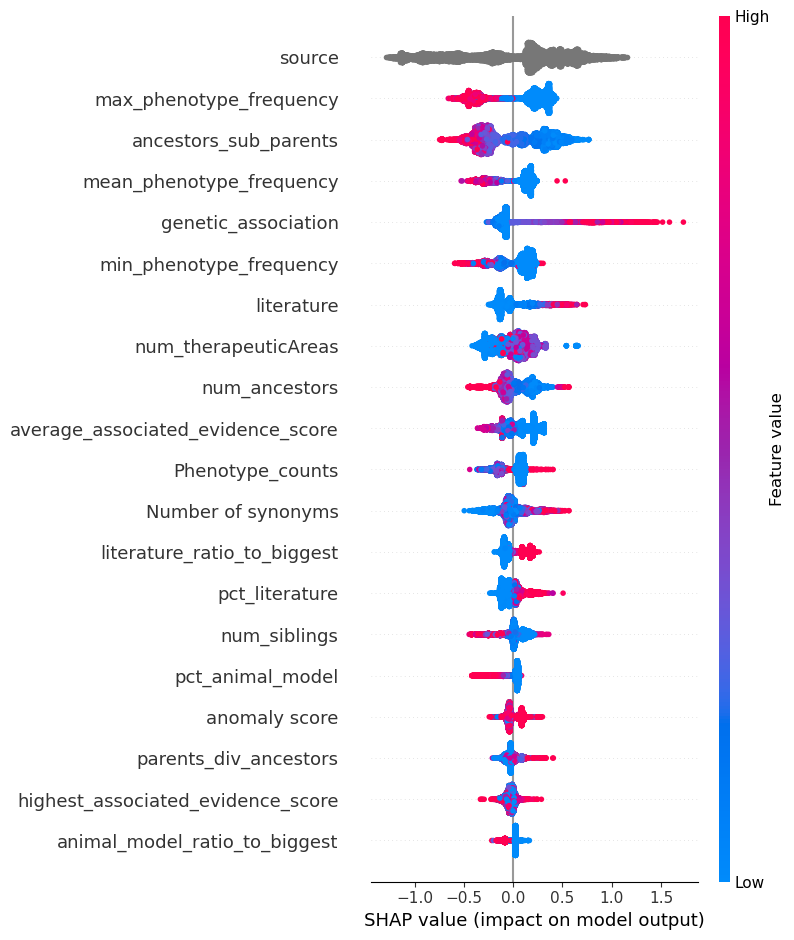

In [105]:
explainer = shap.Explainer(clf)

# #get Shap values from preprocessed data
# shap_values = explainer.shap_values(observations)
shap_values = explainer.shap_values(X,y)
# # # summarize the effects of all the features
# shap.plots.beeswarm(shap_values,max_display=25)

shap.summary_plot(shap_values,X,max_display=20)

In [106]:
if GET_PREDS:
    print("CV without groups")
    preds = cross_val_predict(clf,X,y,method='predict_proba',
                              n_jobs=2,cv=4) ## CV without groupwise!
    print("CV rocAUC",roc_auc_score(y, preds[:,1]))
    print(classification_report(y, preds[:,1]>=0.5)) # 0.827  
    
    ## 5CV without groups CV rocAUC 0.8511

CV without groups
CV rocAUC 0.850101485147324
              precision    recall  f1-score   support

           0       0.82      0.89      0.85     11374
           1       0.74      0.62      0.68      5848

    accuracy                           0.80     17222
   macro avg       0.78      0.76      0.77     17222
weighted avg       0.79      0.80      0.79     17222



In [107]:
%%time
if GET_PREDS:
    print("Groups CV")
    preds = cross_val_predict(clf,X,y,method='predict_proba',
                              n_jobs=-2,
                              groups=df["grp"],cv=StratifiedGroupKFold(4)) # GroupKFold
    print("CV rocAUC",roc_auc_score(y, preds[:,1]))
    print(classification_report(y, preds[:,1]>=0.5)) # 0.848
    
    ## 5CV rocAUC 0.854

Groups CV
CV rocAUC 0.8503618543937178
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     11374
           1       0.72      0.62      0.66      5848

    accuracy                           0.79     17222
   macro avg       0.77      0.75      0.76     17222
weighted avg       0.78      0.79      0.78     17222

CPU times: user 188 ms, sys: 295 ms, total: 483 ms
Wall time: 30.9 s


## TEXT Model
* Use text features - disease name and description "only" 
* Sentence embeddings - `embetter` - 

    * Embetter text embeddings maybe fail when run on cpu? 
    
https://github.com/koaning/embetter#text-example

* Could do combined model, not just seperate , +- text features (word count..)
    * https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html#creating-transformers
    * https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#column-transformer-with-mixed-types  
        * דקךקבאןמע םמךט מוצקרןב בםךדת קאב

In [108]:
if DO_DL:
    df["text"] = "Disease: "+df["name"].fillna("") +". "+ df["description"].fillna("")
    df["text"] = df["text"].str.strip().str[0:990]

In [109]:
X_orig_cols = list(X.columns)


In [110]:
%%time
if DO_DL:
    ### bio-lord: slightly better perf than minilm (89 vs 88 rauc)
    ### ALT embedder:  e5 , or bio-lord ? 
    ### https://huggingface.co/FremyCompany/BioLORD-STAMB2-v1
    model = SentenceTransformer('FremyCompany/BioLORD-STAMB2-v1')
    # model = SentenceTransformer('BAAI/bge-base-en') # ALT - https://huggingface.co/BAAI/bge-base-en
    # model = SentenceTransformer('BAAI/bge-small-en') # ALT - https://huggingface.co/BAAI/bge-base-en # worked - 5 min
    # model = SentenceTransformer("thenlper/gte-small") # thenlper/gte-base
    model.eval() # set eval mode - new
    print("model loaded")
    embeddings = model.encode(df["text"],show_progress_bar=True,normalize_embeddings=True,batch_size = 64) # normalize - new
    X = pd.concat([X,pd.DataFrame(embeddings,index=X.index).add_prefix("dl_")], axis=1)
    display(X)
    if GET_PREDS:
        preds = cross_val_predict(clf,X,y,method='predict_proba',
                                  n_jobs=2,cv=4) ## CV without groupwise!
        print("CV rocAUC",roc_auc_score(y, preds[:,1]))
        print(classification_report(y, preds[:,1]>=0.5))
    
    ### 5CV rocAUC 0.8909 (with FS?)
    
#                   precision    recall  f1-score   support

#            0       0.84      0.92      0.88     11378
#            1       0.82      0.66      0.73      5938

#     accuracy                           0.83     17316
#    macro avg       0.83      0.79      0.81     17316
# weighted avg       0.83      0.83      0.83     17316

No sentence-transformers model found with name /home/ddofer/.cache/torch/sentence_transformers/FremyCompany_BioLORD-STAMB2-v1. Creating a new one with MEAN pooling.


model loaded


Batches:   0%|          | 0/270 [00:00<?, ?it/s]

,animal_model,animal_model_ratio_to_smallest,min_phenotype_frequency,known_drug,total_source_cases,genetic_association_ratio_to_biggest,evidenceCount_byDisease_avg,All_ICD_counts,datasource_nunique,genetic_association_ratio_to_smallest,...,dl_758,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2.0,1.0,2.0,0.0,4.0,1.000,8.250000,0.0,3.0,1.0,...,0.030125,-0.052247,0.007615,0.003228,-0.043482,0.035130,0.007117,0.005671,0.035386,0.021123
10q22.3q23.3 microduplication syndrome,4.0,1.0,0.0,0.0,4.0,0.000,1.000000,0.0,1.0,0.0,...,0.019396,0.001283,0.018512,-0.004181,-0.050078,0.015843,-0.042857,-0.022079,0.036755,-0.017979
11p15.4 microduplication syndrome,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,...,0.004305,-0.052197,-0.014921,-0.000551,-0.045029,-0.007862,0.017467,-0.028892,0.029537,0.026184
12p12.1 microdeletion syndrome,2.0,2.0,14.0,0.0,3.0,0.500,1.000000,0.0,2.0,1.0,...,0.014328,-0.032878,-0.001697,0.004625,-0.045002,0.041962,0.031034,0.016089,0.051643,0.036005
12q14 microdeletion syndrome,169.0,1.0,0.0,0.0,169.0,0.000,1.177515,0.0,1.0,0.0,...,0.025217,-0.033490,-0.008628,0.001113,-0.062398,0.027995,0.015936,0.017756,0.067076,0.049477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,...,-0.001786,0.034138,-0.040213,-0.009371,0.042589,-0.068829,-0.011363,-0.012568,0.027965,0.025432
zygodactyly type 2,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,...,-0.000730,0.033994,-0.040495,-0.015365,0.042242,-0.060812,-0.008457,-0.012942,0.023673,0.018475
zygodactyly type 3,0.0,0.0,0.0,0.0,1.0,1.000,1.000000,0.0,1.0,1.0,...,0.001725,0.036358,-0.041362,-0.006218,0.040948,-0.044446,-0.016768,-0.009939,0.017447,0.022398


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CV rocAUC 0.8868801652892562
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     11374
           1       0.81      0.66      0.73      5848

    accuracy                           0.83     17222
   macro avg       0.82      0.79      0.80     17222
weighted avg       0.83      0.83      0.83     172


* No leaky FS used , and used 4X cv


* FremyCompany/BioLORD-STAMB2-v1
    * Best

```
CV rocAUC 0.8874
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     11374
           1       0.81      0.65      0.72      5848

    accuracy                           0.83     17222
   macro avg       0.82      0.79      0.80     17222
weighted avg       0.83      0.83      0.83     17222
```

* thenlper/gte-base
```
CV rocAUC 0.8854
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     11374
           1       0.82      0.65      0.72      5848

    accuracy                           0.83     17222
   macro avg       0.83      0.79      0.80     17222
weighted avg       0.83      0.83      0.83     17222
```

* BAAI/bge-base-en
```
CV rocAUC 0.88630
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     11374
           1       0.81      0.65      0.72      5848

    accuracy                           0.83     17222
   macro avg       0.82      0.79      0.80     17222
weighted avg       0.83      0.83      0.82     17222
```

* bge-small-en
```
CV rocAUC 0.8789
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     11374
           1       0.81      0.64      0.71      5848

    accuracy                           0.82     17222
   macro avg       0.82      0.78      0.79     17222
weighted avg       0.82      0.82      0.82     17222

CPU times: user 35min 55s, sys: 1min 58s, total: 37min 53s
Wall time: 10min 23s

```



* FremyCompany_BioLORD-STAMB2-v1 ; w/o normalize embedd  (maybe leaky FS was used?) , and 5X cv
    * Better than default minilm (~88 auc)
```
CV rocAUC 0.8911
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     11378
           1       0.82      0.66      0.73      5938

    accuracy                           0.83     17316
   macro avg       0.83      0.79      0.80     17316
weighted avg       0.83      0.83      0.83     17316
```

In [111]:
y.agg(["mean","sum","count"])

mean         0.339566
sum       5848.000000
count    17222.000000
Name: has_children, dtype: float64

In [112]:
df_temp = X.copy()
df_temp["has_children"] = y.values
df_temp["source"] = lbl.inverse_transform(df_temp.source.astype(int))
# df_temp.columns = df_temp.columns.astype(str)
if SAVE_OUTPUT:
    df_temp.to_parquet("features_data_DL_export.parquet")
display(df_temp)

,animal_model,animal_model_ratio_to_smallest,min_phenotype_frequency,known_drug,total_source_cases,genetic_association_ratio_to_biggest,evidenceCount_byDisease_avg,All_ICD_counts,datasource_nunique,genetic_association_ratio_to_smallest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2.0,1.0,2.0,0.0,4.0,1.000,8.250000,0.0,3.0,1.0,...,-0.052247,0.007615,0.003228,-0.043482,0.035130,0.007117,0.005671,0.035386,0.021123,0
10q22.3q23.3 microduplication syndrome,4.0,1.0,0.0,0.0,4.0,0.000,1.000000,0.0,1.0,0.0,...,0.001283,0.018512,-0.004181,-0.050078,0.015843,-0.042857,-0.022079,0.036755,-0.017979,0
11p15.4 microduplication syndrome,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,...,-0.052197,-0.014921,-0.000551,-0.045029,-0.007862,0.017467,-0.028892,0.029537,0.026184,0
12p12.1 microdeletion syndrome,2.0,2.0,14.0,0.0,3.0,0.500,1.000000,0.0,2.0,1.0,...,-0.032878,-0.001697,0.004625,-0.045002,0.041962,0.031034,0.016089,0.051643,0.036005,0
12q14 microdeletion syndrome,169.0,1.0,0.0,0.0,169.0,0.000,1.177515,0.0,1.0,0.0,...,-0.033490,-0.008628,0.001113,-0.062398,0.027995,0.015936,0.017756,0.067076,0.049477,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,...,0.034138,-0.040213,-0.009371,0.042589,-0.068829,-0.011363,-0.012568,0.027965,0.025432,0
zygodactyly type 2,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,...,0.033994,-0.040495,-0.015365,0.042242,-0.060812,-0.008457,-0.012942,0.023673,0.018475,0
zygodactyly type 3,0.0,0.0,0.0,0.0,1.0,1.000,1.000000,0.0,1.0,1.0,...,0.036358,-0.041362,-0.006218,0.040948,-0.044446,-0.016768,-0.009939,0.017447,0.022398,0


* Get predictions

,id,name,has_children,pred_1,description,error
6769,EFO_0000508,genetic disorder,1,0.999,Genetic diseases are diseases in which inherit...,0.001
9808,MONDO_0021069,malignant endocrine neoplasm,1,0.998,A malignant neoplasm affecting the endocrine g...,0.002
4365,MONDO_0021581,connective tissue neoplasm,1,0.998,"Neoplasms composed of connective tissue, inclu...",0.002
6359,MONDO_0021148,female reproductive system neoplasm,1,0.997,"A benign, precancerous, or malignant neoplasm ...",0.003
9592,EFO_0000571,lung adenocarcinoma,1,0.997,A carcinoma that arises from the lung and is c...,0.003
...,...,...,...,...,...,...
739,Orphanet_2952,"adducted thumbs - arthrogryposis, christian type",0,0.003,"Adducted thumbs-arthrogryposis, Christian type...",0.003
17079,MONDO_0010729,"x-linked intellectual disability, schimke type",0,0.003,"X-linked mental retardation, Schimke type, is ...",0.003
4523,Orphanet_52054,craniosynostosis - intracranial calcifications,0,0.003,Craniosynostosis - intracranial calcifications...,0.003
4567,Orphanet_1547,cryptomicrotia - brachydactyly - excess finger...,0,0.003,Cryptomicrotia - brachydactyly - excess finger...,0.003


Orphanet RocAUC: 94.1
Mean error: 0.178
2061 cases; 0.83 target ratio over prior
MONDO RocAUC: 90.4
Mean error: 0.236
8801 cases; 1.1 target ratio over prior
HP RocAUC: 80.9
Mean error: 0.319
1366 cases; 0.95 target ratio over prior
EFO RocAUC: 83.8
Mean error: 0.275
4590 cases; 0.84 target ratio over prior
GO RocAUC: 74.0
Mean error: 0.389
352 cases; 1.67 target ratio over prior
CPU times: user 624 ms, sys: 742 ms, total: 1.37 s
Wall time: 58.4 s


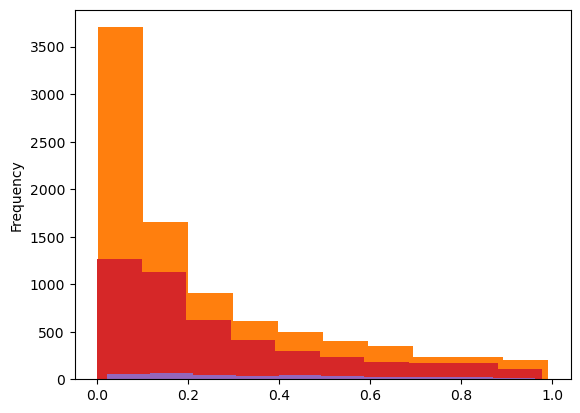

In [113]:
%%time
if GET_PREDS or DO_ESEARCH:
    preds = cross_val_predict(clf,X,y,method='predict_proba',n_jobs=2,cv=5)
    df["pred_1"]  = preds[:,1]
    df_res = df[["id","name","has_children","pred_1","description"]].sort_values(["has_children","pred_1"],ascending=[True,False,])
    df_res["name"] = df_res["name"].str.lower()
    df_res = df_res.round(3)
    df_res.drop_duplicates(subset=["name"],inplace=True)
    ## pred error , by class
    df_res["error"] = abs((df_res["has_children"] - df_res["pred_1"]).round(3))
    df_res.sort_values(["pred_1"],ascending=False,inplace=True)
    display(df_res)

    df["error"] = abs((df_res["has_children"] - df_res["pred_1"]).round(3))
    for s in df["source"].unique():     
        df_temp = df.loc[df["source"]==s]   
        if df_temp.shape[0]>50:
            y1 = df_temp["has_children"]
            y2 = df_temp["pred_1"]
            try:
                print(f"{s} RocAUC:",round(100*roc_auc_score(y1,y2),1))
                print("Mean error:",round(df_temp["error"].mean(),3))
                print(df_temp.shape[0],"cases;",round((y1.mean()/y.mean()),2),"target ratio over prior")
            except:(f"{s} error")
#             df_temp.groupby(["source"])["has_children"].plot(kind="kde")
            df_temp.groupby(["source"])["error"].plot(kind="hist")
    df.drop(columns=["error"],errors="ignore",inplace=True)

    
    if SAVE_OUTPUT:
        df_res.to_csv("predictions_v2_openTarget_has_children.csv.gz",index=False,compression="gzip")

## OPT : Get pubmed search results counts for terms +- subtype/pleitropy
* note - slow, urls

Base on (?):
```
Since there is no gold standard to evaluate such novel predictions for indication expansion or drug repurposing potential, we utilized the scientific literature as an external source of validation by retrieving suggested drug targets from published articles and checking what proportion of these were predicted with our model. Specifically, we searched for literature hits of a gene or protein being mentioned as a (potential) therapeutic target in titles and abstracts on MEDLINE. 
We found a large number of text mining instances corresponding to 6,696 unique diseases that co-occurred with the 2,858 druggable genomes. There were 1,247 in common diseases between the predicted set and text mining hits, representing a highly significant proportion as assessed by hypergeometric test (p = 6.33e-113) (Fig. 4d; Additional file 7: Table 3). 
```

In [114]:
%%time
from Bio import Entrez
from time import sleep
from scipy.stats import ttest_rel, chisquare

## https://biopython.org/docs/1.76/api/Bio.Entrez.html
if DO_ESEARCH:
    df_res.sort_values(["pred_1"],ascending=False,inplace=True)
    # df_sample = pd.concat([df_res.head(150),df_res.tail(150)],ignore_index=True) # was 150
    df_sample = pd.concat([df_res.head(400),df_res.tail(400)],ignore_index=True) # was 150
    
#     Entrez.email = ""
    pubmed_count_1 = []
    pubmed_count_2 = []
    ## add total res in search? 
    for n in list(df_sample["name"]):
        print(n)
        # handle = Entrez.egquery(term="genetic eye tumor")
        ##OLD, orig: f"{n} AND ((subtype) OR (pleiotropy))"
        ## oops, should be "AND" no t not. I will flip
        handle_1 = Entrez.egquery(term = f"((({n}) NOT (subtype)) NOT (pleiotropy)) NOT (submanifest)")
        ##OLD, orig handle 2: was "not "x . Now it is total X. 
#         handle_2 = Entrez.egquery(term = f"{n} NOT ((subtype) OR (pleiotropy))")
        handle_2 = Entrez.egquery(term = f"{n}")

        record_1 = Entrez.read(handle_1)
        record_2 = Entrez.read(handle_2)

        for row in record_1["eGQueryResult"]:
            if row["DbName"] == "pubmed":
                pubmed_count_1.append(row["Count"])
        for row in record_2["eGQueryResult"]:
            if row["DbName"] == "pubmed":
                pubmed_count_2.append(row["Count"])
        sleep(0.012)
    pubmed_count_1 = pd.to_numeric(pubmed_count_1)
    pubmed_count_2 = pd.to_numeric(pubmed_count_2)
    ## add total? 

CPU times: user 23 µs, sys: 4 µs, total: 27 µs
Wall time: 31 µs


In [115]:
if DO_ESEARCH:
    df_groups = pd.DataFrame({"results count - subtype AND res":pubmed_count_2-pubmed_count_1,
                              "total":pubmed_count_2},index=df_sample["name"])
    # df_groups["total"] = pubmed_count_1+pubmed_count_2 # ORIG/old
    # df_groups["total"] = pubmed_count_2
    
    mid = df_groups.shape[0]//2
    df_groups["group"] = 1
    df_groups["group"].iloc[mid:] = 0
    
    df_groups["freq_subtype"] = df_groups["results count - subtype AND res"].div(df_groups["total"])
    # df_groups["freq_no_subtype"] = pubmed_count_2/df_groups["total"]
    display(df_groups)

    if SAVE_OUTPUT:
        # df_groups.to_csv("300_esearch_res.csv")
        df_groups.to_csv("outputs/800_esearch_res.csv")

In [116]:
if DO_ESEARCH:
    print(df_groups.reset_index(drop=True))

In [117]:
# ttest_rel(pubmed_count_1[mid:], pubmed_count_2[mid:],alternative="less")

In [118]:
df_groups.groupby("group").mean().T.round(3)

NameError: name 'df_groups' is not defined

In [ ]:
ttest_ind(a=df_groups["freq_subtype"].head(mid).values,
          b=df_groups["freq_subtype"].tail(mid).values,
          equal_var=False,alternative="greater",nan_policy="omit")

In [ ]:
ttest_ind(a=df_groups["freq_subtype"].head(mid).values,
          b=df_groups["freq_subtype"].tail(mid).values,
          equal_var=False,alternative="less",nan_policy="omit")

In [ ]:
ttest_ind(a=df_groups["results count - subtype AND res"].head(mid).values,
          b=df_groups["results count - subtype AND res"].tail(mid).values,
          equal_var=False,alternative="greater",nan_policy="omit")